Line to Drive files for cell-phone dataset: https://drive.google.com/file/d/1ET7rXNa5vAhWNLK6YQsbuQsiQNavO2sL/view?usp=share_link

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing...

In [ ]:
import pandas as pd
import numpy as np
import torch
import json
import matplotlib.pyplot as plt
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.metrics import ndcg_score
import torch.nn.functional as F
np.random.seed(0)

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Cell_Phones_and_Accessories.json.gz --no-check-certificate 

--2023-01-19 09:36:51--  https://jmcauley.ucsd.edu/data/amazon_v2/categoryFiles/Cell_Phones_and_Accessories.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1232323281 (1.1G) [application/x-gzip]
Saving to: ‘Cell_Phones_and_Accessories.json.gz’

Cell_Phones_and_Acc 100%[===================>]   1.15G  17.5MB/s    in 69s     

2023-01-19 09:38:01 (17.0 MB/s) - ‘Cell_Phones_and_Accessories.json.gz’ saved [1232323281/1232323281]



In [ ]:
!gunzip Cell_Phones_and_Accessories.json.gz

In [ ]:
!wget https://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_Cell_Phones_and_Accessories.json.gz --no-check-certificate 

--2023-01-19 09:38:35--  https://jmcauley.ucsd.edu/data/amazon_v2/metaFiles2/meta_Cell_Phones_and_Accessories.json.gz
Resolving jmcauley.ucsd.edu (jmcauley.ucsd.edu)... 137.110.160.73
Connecting to jmcauley.ucsd.edu (jmcauley.ucsd.edu)|137.110.160.73|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 360006372 (343M) [application/x-gzip]
Saving to: ‘meta_Cell_Phones_and_Accessories.json.gz’

meta_Cell_Phones_an 100%[===================>] 343.33M  17.5MB/s    in 21s     

2023-01-19 09:38:57 (16.3 MB/s) - ‘meta_Cell_Phones_and_Accessories.json.gz’ saved [360006372/360006372]



In [ ]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import FreqDist
import re
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize,pos_tag
import pandas as pd

In [ ]:
save_path='/content/drive/MyDrive/cell_phone/'

In [ ]:
df_review=pd.read_csv(save_path+'df_reviews.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df_meta=pd.read_csv(save_path+'df_meta.csv')

In [ ]:
import glob
items_list=[]
names=glob.glob(save_path+"description_bert/*.json")
for name in names:
  # items_dframe=pd.read_json(name)
  item_id=name.split('/')[-1].split('_')[-1][0:-5]
  items_list.append(item_id)


In [ ]:
print('B014QE0N8O' in items_list)

True


In [ ]:
len(items_list)

1940

In [ ]:
df_review.drop(df_review.index[~df_review['asin'].isin(items_list)], inplace=True) 

In [ ]:
# df_review=df_review[df_review['reviewerID'].isin(df_review['reviewerID'].value_counts()[df_review['reviewerID'].value_counts()>=5].index)]
# df_review=df_review[df_review['asin'].isin(df_review['asin'].value_counts()[df_review['asin'].value_counts()>=10].index)]

In [ ]:
df_review

In [ ]:
df_review.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df_review.drop_duplicates(inplace=True)

In [ ]:
df_review

,overall,reviewerID,asin,unixReviewTime,vote
1075,1.0,AQL4Y2G5IMTLH,B0004OPNTA,1154563200,27.0
1076,5.0,A24ELVKE7L81X1,B0004OPNTA,1139184000,3.0
1077,5.0,A4SASFK7TLPGY,B0004OPNTA,1130630400,3.0
1078,5.0,A1T9HX66DMGN6S,B0004OPNTA,1130457600,21.0
1079,1.0,A34TC14MCJXDK7,B0004OPNTA,1116892800,15.0
...,...,...,...,...,...
3793055,5.0,A3BI52GIXW9N06,B01HCH03HS,1538006400,NaN
3793056,5.0,A1UVJ55JU0U81S,B01HCH03HS,1537920000,NaN
3793057,5.0,A2N2ETUGNPSDJD,B01HCH03HS,1537747200,NaN
3793058,5.0,A3HRMHWLAUY1A3,B01HCH03HS,1537574400,NaN


In [ ]:
items_list1=[]
users_list=[]
review_features={}
f=open(save_path+'Cell_Phones_and_Accessories')
lines=f.readlines()
i=0
for line in lines:
  if i%5000==0:
    print(i)
  i+=1
  user_id = line.split('@')[0]
  item_id = line.split('@')[1]
  if item_id in items_list:
    users_list.append(user_id)
    items_list1.append(item_id)
    l = len(user_id) + len(item_id)
    fosr_data = line[l+3:]
    for seg in fosr_data.split('||'):
      if (user_id,item_id) not in review_features.keys():
        review_features[(user_id,item_id)]=[]
      fos = seg.split(':')[0].strip('|')
      if len(fos.split('|')) > 1:
          feature = fos.split('|')[0]
          opinion = fos.split('|')[1]
          sentiment = fos.split('|')[2]
          sentence= seg.split(':')[1]
          if sentiment=='+1':
            senti=1
          else:
            senti=-1
          review_features[(user_id,item_id)].append([feature,opinion,senti,sentence])

0
5000
10000
15000
20000
25000
30000
35000


In [ ]:
df_review=df_review[df_review.set_index(['reviewerID','asin']).index.isin(review_features.keys())]

In [ ]:
df_review

,overall,reviewerID,asin,unixReviewTime,vote
1182,5.0,AHO9V8YUQ2G3Q,B0004OPNTA,1405123200,NaN
1258,5.0,A2MXCDMK91S143,B0004OPNTA,1354492800,NaN
1290,5.0,A2FD834RITVVXH,B0004OPNTA,1316131200,NaN
1516,3.0,A39EN5XP8LDVX8,B0006TIA8Y,1367884800,NaN
1523,5.0,A2P68VRKQMYBDE,B0006TIA8Y,1363305600,NaN
...,...,...,...,...,...
3747249,5.0,AMS2CPERWN7JV,B01DK7T4M4,1468368000,NaN
3766849,3.0,A1LYAOOXZFWB20,B01F5VMRCM,1513382400,NaN
3773744,5.0,ARHQG5T73YT3R,B01FSV8782,1536624000,NaN
3773792,5.0,ARHQG5T73YT3R,B01FSVN3W2,1536624000,NaN


In [ ]:
sentires_dir='/content/drive/MyDrive/cell_phone/Cell_Phones_and_Accessories'
test_length=10
sample_ratio=5
val_length=5
neg_length=100
dataset='cell_phone'
save_path='/content/drive/MyDrive/cell_phone/'

In [ ]:
def get_user_item_dict(df_review,items_list):
  user_dict = {}
  item_dict = {}
  j=0
  # removed_users=['A1ULCCHD1QNOS5','A1ZS098EKPVT8F','A1K1WK6I122RX2','A2PAFKGAUSBMIE','AAOYA0DKWED4W','AJS9Q2JYS3DLJ','ADOF1VKGDCBWF','A3G11XDKGXZT9Q','A1R233YLWSRBTC','A3VH9QMH2UTX9D','A15DZOS6KVANQH']    
  for index, row in df_review.iterrows():
    if j%100000==0:
      print(j)
    j+=1
    user=row['reviewerID']
    item=row['asin']
    if item in items_list:
      if user not in user_dict:
          user_dict[user] = [item]
      else:
          user_dict[user].append(item)
      if item not in item_dict:
          item_dict[item] = [user]
      else:
          item_dict[item].append(user)
  return user_dict,item_dict

In [ ]:
df_meta.loc[df_meta['feature'].str.len()<15]

In [ ]:
def get_average_vect_train(df,not_in_columns):
  df['main_word']=np.where(df['replaced_word'] == df[not_in_columns],1,0)
  df=df[df['main_word']==1]
  lists=df.loc[:, ~df.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  average=np.average(np.array(vects),axis=0)
  # print(words)
  # print(df)
  return average,list(words)

In [ ]:
def get_average_vect_test(weights,tensor_vect):
  # weights=torch.FloatTensor(weights).to(device)
  weights=torch.transpose(weights.repeat(tensor_vect.shape[1],1),0,1)
  average=torch.mean(weights*tensor_vect,axis=0).to(device)
  return average

In [ ]:
import os

In [ ]:
from typing_extensions import final
def get_item_matrix(item_name_dict,items_list):
  print('----- get items matrix -------')
  item_quality_matrix = np.zeros((len(item_name_dict), 2304))
  print((len(item_name_dict)))
  i=0
  features={}
  for item_id in items_list:
    if item_id in item_name_dict.keys():
      item=item_name_dict[item_id]
      features[item]=[]
      if i%100==0:
        print(i)
      i+=1
      final_vector=[]
      # print(item_id)
      df_vect_desc_item= pd.read_json(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id))
      df_vect_title_item= pd.read_json(save_path+'title_bert/'+'df_bert_title_{}.json'.format(item_id))
      df_vect_feature_item= pd.read_json(save_path+'feature_bert/'+'df_bert_feature_{}.json'.format(item_id))

      # print(item_id)
      # print(df_vect_desc_item)

      average_vect_desc,words_desc=get_average_vect_train(df_vect_desc_item,'description_words')
      average_vect_title,words_title=get_average_vect_train(df_vect_title_item,'title_words')
      average_vect_feature,words_feature=get_average_vect_train(df_vect_feature_item,'feature_words')

      features[item].append(words_desc)
      features[item].append(words_title)
      features[item].append(words_feature)
      # features[item].append(words_senti)
      # features[item].append([rank])
      final_vector=list(average_vect_desc)
      final_vector+=list(average_vect_title)
      final_vector+=list(average_vect_feature)
  # final_vector+=list(average_bert_sentiment)
  # final_vector+=[rank]
  
      if len(final_vector)>2304:
          print(len(list(average_vect_desc)))
          print(len(list(average_vect_title)))
          print(len(list(average_vect_feature)))
          # print(len(list(average_bert_sentiment)))
          print(item_id)
      item_quality_matrix[item]=final_vector
      # print(item_quality_matrix)

  item_quality_matrix = np.array(item_quality_matrix, dtype='float32')
  return item_quality_matrix,features

In [ ]:
def get_user_matrix(item_matrix,inv_user_name_dict,item_name_dict):
  user_quality_matrix = np.zeros((len(inv_user_name_dict), 2304))
  i=0
  print('----- get users matrix -------')
  print((len(inv_user_name_dict)))
  for  user in inv_user_name_dict.keys():
    if i%1000==0:
      print(i)
    i+=1
    user_id= inv_user_name_dict[user]
    final_vector=[]
    items_interacted=df_review[df_review['reviewerID']==user_id ]
    # mean_rate=np.average(items_interacted['overall'].values)
    # weights=[]
    for item_id in items_interacted['asin'].values:
      if item_id in item_name_dict.keys():
        item=item_name_dict[item_id]
        # weight=items_interacted[items_interacted['asin']==item_id]['overall'].values[0]-mean_rate
        # weights.append(weight)
        final_vector.append(item_matrix[item])
    # if np.sum(weights)>0 or np.sum(weights)<0:
    #   final_average=np.average(final_vector,weights=weights,axis=0)
    # else:
    final_average=np.average(final_vector,axis=0)
    if ~np.isnan(np.sum(final_average)):
      user_quality_matrix[user]=final_average
    else:
      print(user_id)
  user_quality_matrix = np.array(user_quality_matrix, dtype='float32')
  return user_quality_matrix

In [ ]:
def sample_training_pairs(user, training_items, item_set, sample_ratio=5):
    positive_items = set(training_items)
    negative_items = set()
    for item in item_set:
        if item not in positive_items:
            negative_items.add(item)
    neg_length = len(positive_items) * sample_ratio
    negative_items = np.random.choice(np.array(list(negative_items)), neg_length, replace=False)
    train_pairs = []
    for p_item in positive_items:
        train_pairs.append([user, p_item, 1])
    for n_item in negative_items:
        train_pairs.append([user, n_item, 0])
    return train_pairs

In [ ]:
user_dict,item_dict=get_user_item_dict(df_review,items_list)

0


In [ ]:
from re import S
import torch
import numpy as np
import json
import pickle
# from torch._C import R
import tqdm
from torch.random import seed


class AmazonDataset():
    def __init__(self):
        super().__init__()

        self.user_name_dict = {}  # rename users to integer names
        self.item_name_dict = {}
        # self.feature_name_dict = {}

        self.features = {}  # feature list
        self.users = []
        self.items = []

        # the interacted items for each user, sorted with date {user:[i1, i2, i3, ...], user:[i1, i2, i3, ...]}
        self.user_hist_inter_dict = {}
        # the interacted users for each item
        self.item_hist_inter_dict = {}  

        self.user_num = None
        self.item_num = None
        self.feature_num = 2304# number of features

        self.user_feature_matrix = None  # user aspect attention matrix
        self.item_feature_matrix = None  # item aspect quality matrix

        self.training_data = None
        self.test_data = None
        self.pre_processing()
        self.get_user_item_feature_matrix()
        self.sample_training()  # sample training data, for traning BPR loss
        self.sample_test()  # sample test data

    def pre_processing(self,):
        self.items_list=items_list
        user_dict, item_dict = get_user_item_dict(df_review,self.items_list)  # not sorted with time
        self.items_list=list(item_dict.keys())
        print('num_items: ',len(item_dict))
        user_item_date_dict = {}   # {(user, item): date, (user, item): date ...}  # used to remove duplicate
        # # removed_users=['A1ULCCHD1QNOS5','A1ZS098EKPVT8F','A1K1WK6I122RX2','A2PAFKGAUSBMIE','AAOYA0DKWED4W','AJS9Q2JYS3DLJ','ADOF1VKGDCBWF','A3G11XDKGXZT9Q','A1R233YLWSRBTC','A3VH9QMH2UTX9D','A15DZOS6KVANQH']
        # print(df_review.shape)
        for i, row in df_review.iterrows():
            user = row['reviewerID']
            # if user not in removed_users:
            item = row['asin']
            date = row['unixReviewTime']
            if item in self.items_list:
              if user in user_dict and item in user_dict[user] and (user, item) not in user_item_date_dict:
                  user_item_date_dict[(user, item)] = date
        
        # rename users, items, and features to integer names
        user_name_dict = {}
        item_name_dict = {}
        # feature_name_dict = {}
        # features = get_feature_list(df_bert_sentiment,df_bert_desc,)
        
        count = 0
        for user in user_dict:
            if user not in user_name_dict:
                user_name_dict[user] = count
                count += 1
        count = 0
        for item in item_dict:
            if item not in item_name_dict:
                item_name_dict[item] = count
                count += 1
        self.inv_user_name_dict = {v: k for k, v in user_name_dict.items()}
        self.inv_item_name_dict = {v: k for k, v in item_name_dict.items()}
        

        renamed_user_item_date_dict = {}
        for key, value in user_item_date_dict.items():
            renamed_user_item_date_dict[user_name_dict[key[0]], item_name_dict[key[1]]] = value

        # sort with date
        renamed_user_item_date_dict  = dict(sorted(renamed_user_item_date_dict .items(), key=lambda item: item[1]))

        user_hist_inter_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}, sort with time
        item_hist_inter_dict = {}
        # ranked_user_item_dict = {}  # {"u1": [i1, i2, i3, ...], "u2": [i1, i2, i3, ...]}
        for key, value in renamed_user_item_date_dict.items():
            user = key[0]
            item = key[1]
            if user not in user_hist_inter_dict:
                user_hist_inter_dict[user] = [item]
            else:
                user_hist_inter_dict[user].append(item)
            if item not in item_hist_inter_dict:
                item_hist_inter_dict[item] = [user]
            else:
                item_hist_inter_dict[item].append(user)

        user_hist_inter_dict = dict(sorted(user_hist_inter_dict.items()))
        item_hist_inter_dict = dict(sorted(item_hist_inter_dict.items()))

        users = list(user_hist_inter_dict.keys())
        items = list(item_hist_inter_dict.keys())

        self.user_name_dict = user_name_dict
        self.item_name_dict = item_name_dict
        self.user_hist_inter_dict = user_hist_inter_dict
        self.item_hist_inter_dict = item_hist_inter_dict
        self.users = users
        self.items = items
        self.user_num = len(users)
        self.item_num = len(items)
        return True
    
    def get_user_item_feature_matrix(self,):
        # exclude test data from the sentiment data to construct matrix
        train_u_i_set = set()
        for user, items in self.user_hist_inter_dict.items():
            items = items[:-test_length]
            for item in items:
                train_u_i_set.add((user, item))

        self.item_feature_matrix,self.item_features= get_item_matrix(self.item_name_dict,self.items_list)
        self.user_feature_matrix = get_user_matrix(self.item_feature_matrix,self.inv_user_name_dict,self.item_name_dict)
        
        return True
    
    def sample_training(self):
        print('======================= sample training data =======================')
        training_data = []
        training_pairs = np.loadtxt(save_path+'training_data.txt',dtype=str)
        for pair in training_pairs:
          # print(self.user_name_dict)
          # print(pair[0])
          if pair[0] in self.user_name_dict.keys() and pair[1] in self.item_name_dict.keys():
            training_data.append([self.user_name_dict[pair[0]],self.item_name_dict[pair[1]],int(pair[2])])


        # print(self.user_feature_matrix.shape, self.item_feature_matrix.shape)
        # training_data = []
        # item_set = set(self.items)
        # for user, items in self.user_hist_inter_dict.items():
        #     if len(items)>15:
        #       items = items[:-(test_length)]
        #       training_pairs = sample_training_pairs(
        #           user, 
        #           items, 
        #           item_set, 
        #           sample_ratio)
        #       for pair in training_pairs:
        #           training_data.append(pair)
        print('# training samples :', len(training_data))
        self.training_data = np.array(training_data)
      
        return True
    
    def sample_test(self):
        print('======================= sample test data =======================')
        user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        with open(save_path+'test_data.pickle', 'rb') as f:
            test_pairs= pickle.load(f)
        for user_id in test_pairs.keys():
          user=self.user_name_dict[user_id]
          items_ids=test_pairs[user_id][0]
          labels=test_pairs[user_id][1]
          items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict])
          labels=np.array([float(labels[i]) for i in range(len(labels)) if items_ids[i] in self.item_name_dict])
          user_item_label_list.append([user,items,labels])
        print('# test samples :', len(user_item_label_list))
        self.test_data = np.array(user_item_label_list)

        # validation_data = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        # with open(save_path+'validation_data.pickle', 'rb') as f:
        #     validation_pairs= pickle.load(f)
        # for user_id in validation_pairs.keys():
        #   user=self.user_name_dict[user_id]
        #   items_ids=validation_pairs[user_id][0]
        #   labels=validation_pairs[user_id][1]
        #   items=np.array([self.item_name_dict[item] for item in items_ids if item in self.item_name_dict])
        #   labels=np.array([float(labels[i]) for i in range(len(labels)) if items_ids[i] in self.item_name_dict])
        #   validation_data.append([user,items,labels])
        # print('# validation samples :', len(validation_data))
        # self.validation_data = np.array(validation_data)


        # user_item_label_list = []  # [[u, [item1, item2, ...], [l1, l2, ...]], ...]
        # validation_data=[]
        # for user, items in self.user_hist_inter_dict.items():
        #   if len(items)>15:
        #     # print(items)
        #     items1 = items[-(test_length):-(val_length)]
        #     items2 = items[-(val_length):]
        #     # print(items1)
        #     # print(items2)
        #     user_item_label_list.append([user, items1, np.ones(len(items1))])  # add the test items
        #     validation_data.append([user, items2, np.ones(len(items2))])
        #     neg_length1=len(items1)*5
        #     neg_length2=len(items2)*5
        #     negative_items1 = [item for item in self.items if 
        #         item not in self.user_hist_inter_dict[user]]  # the not interacted items
        #     # print(len(negative_items1))
        #     negative_items1 = np.random.choice(np.array(negative_items1), neg_length1, replace=False)
        #     negative_items2 = np.random.choice(np.array(negative_items1), neg_length2, replace=False)

        #     user_item_label_list[-1][1] = np.concatenate((user_item_label_list[-1][1], negative_items1), axis=0)
        #     user_item_label_list[-1][2] = np.concatenate((user_item_label_list[-1][2], np.zeros(neg_length1)), axis=0)

        #     validation_data[-1][1] = np.concatenate((validation_data[-1][1], negative_items2), axis=0)
        #     validation_data[-1][2] = np.concatenate((validation_data[-1][2], np.zeros(neg_length2)), axis=0)
        # print('# test samples :', len(user_item_label_list))
        # print('# validation samples :', len(validation_data))
        # self.test_data = np.array(user_item_label_list)
        # self.validation_data=np.array(validation_data)
        return True

    def save(self, save_path):
        return True
    
    def load(self):
        return False

In [ ]:
len(rec_dataset.test_data[2][1])

In [ ]:
def amazon_preprocessing():
    rec_dataset = AmazonDataset()
    return rec_dataset

In [ ]:
def dataset_init():
	if dataset == "yelp":
		rec_dataset = yelp_preprocessing()
	elif dataset == "cell_phones" or "kindle_store" or "electronic" or "cds_and_vinyl":
		rec_dataset = amazon_preprocessing()
	return rec_dataset

In [ ]:
dataset="cell_phones"
gpu=True
cuda='0'
weight_decay=0.00001
lr=0.01
epochs=500
batch_size=64
rec_k=5

In [ ]:
import numpy as np
from torch.utils.data import Dataset
class UserItemInterDataset(Dataset):
    def __init__(self, data, user_feature_matrix, item_feature_matrix):
        self.data = data
        self.user_feature_matrix = user_feature_matrix
        self.item_feature_matrix = item_feature_matrix

    def __getitem__(self, index):
        user = self.data[index][0]
        item = self.data[index][1]
        label = self.data[index][2]
        user_feature = self.user_feature_matrix[user]
        item_feature = self.item_feature_matrix[item]
        return user_feature, item_feature, label
    def __len__(self):
        return len(self.data)

# Train Black-box model...

In [ ]:
import numpy as np
import torch
from sklearn.metrics import ndcg_score

In [ ]:
def compute_ndcg(test_data, user_feature_matrix, item_feature_matrix, k, model, device):
    model.eval()
    ndcgs = []
    with torch.no_grad():
        for row in test_data:
            user = row[0]
            items = row[1]
            gt_labels = row[2]
            user_features = np.array([user_feature_matrix[user] for i in range(len(items))])
            item_features = np.array([item_feature_matrix[item] for item in items])
            scores = model(torch.from_numpy(user_features).to(device),
                                    torch.from_numpy(item_features).to(device)).squeeze()
            # print(scores)
            # print(gt_labels)                        
            scores = np.array(scores.to('cpu'))
            ndcg = ndcg_score([gt_labels], [scores], k=k)
            ndcgs.append(ndcg)
    ave_ndcg = np.mean(ndcgs)
    return ave_ndcg


In [ ]:
import torch
import numpy as np
import os
import tqdm
import pickle
from pathlib import Path
from torch.utils.data import DataLoader

In [ ]:
from numpy import core

class BaseRecModel(torch.nn.Module):
    def __init__(self, feature_length):
        super(BaseRecModel, self).__init__()
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(feature_length * 2, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 1),
            torch.nn.Sigmoid()
        )

    def forward(self, user_feature, item_feature):
        fusion = torch.cat((user_feature, item_feature), 1)
        out = self.fc(fusion)
        return out


In [ ]:
if gpu:
  device = torch.device('cuda:%s' % cuda)
else:
  device = 'cpu'
print(device)

cuda:0


In [ ]:
rec_dataset = dataset_init()

0
num_items:  1940
----- get items matrix -------
1940
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
----- get users matrix -------
6783
0
1000
2000
3000
4000
5000
6000
======================= sample training data =======================
# training samples : 2858
======================= sample test data =======================
# test samples : 93


<ipython-input-25-44906a73d21d>:172: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.test_data = np.array(user_item_label_list)


In [ ]:
Path(save_path).mkdir(parents=True, exist_ok=True)
with open(os.path.join(save_path,dataset + "_dataset_obj_Gumbel.pickle"), 'wb') as outp:
   pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(os.path.join(save_path, dataset + "_dataset_obj_Gumbel.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
import matplotlib.pyplot as plt

Using CPU
init ndcg: 0.09603078199016701


  0%|          | 0/500 [00:00<?, ?it/s]

epoch 0:  training loss:  0.66067535


  0%|          | 1/500 [00:02<23:49,  2.87s/it]

epoch 0:  training loss:  0.66067535 NDCG_validation:  0.12113219648835566


  0%|          | 2/500 [00:04<19:03,  2.30s/it]

epoch 1:  training loss:  0.63828695


  1%|          | 3/500 [00:06<16:45,  2.02s/it]

epoch 2:  training loss:  0.6349782


  1%|          | 4/500 [00:07<14:14,  1.72s/it]

epoch 3:  training loss:  0.63407904


  1%|          | 5/500 [00:08<12:38,  1.53s/it]

epoch 4:  training loss:  0.6326144


  1%|          | 6/500 [00:10<11:35,  1.41s/it]

epoch 5:  training loss:  0.63207185


  1%|▏         | 7/500 [00:11<10:58,  1.34s/it]

epoch 6:  training loss:  0.6314249


  2%|▏         | 8/500 [00:12<10:30,  1.28s/it]

epoch 7:  training loss:  0.62963045


  2%|▏         | 9/500 [00:13<10:09,  1.24s/it]

epoch 8:  training loss:  0.62904745


  2%|▏         | 10/500 [00:14<09:55,  1.22s/it]

epoch 9:  training loss:  0.6285547
epoch 10:  training loss:  0.62755513


  2%|▏         | 11/500 [00:16<11:24,  1.40s/it]

epoch 10:  training loss:  0.62755513 NDCG_validation:  0.20556222869778987


  2%|▏         | 12/500 [00:17<10:47,  1.33s/it]

epoch 11:  training loss:  0.62585104


  3%|▎         | 13/500 [00:18<10:26,  1.29s/it]

epoch 12:  training loss:  0.625431


  3%|▎         | 14/500 [00:20<10:13,  1.26s/it]

epoch 13:  training loss:  0.62368006


  3%|▎         | 15/500 [00:21<10:03,  1.24s/it]

epoch 14:  training loss:  0.622511


  3%|▎         | 16/500 [00:22<09:52,  1.22s/it]

epoch 15:  training loss:  0.62027705


  3%|▎         | 17/500 [00:23<09:50,  1.22s/it]

epoch 16:  training loss:  0.6190137


  4%|▎         | 18/500 [00:24<09:44,  1.21s/it]

epoch 17:  training loss:  0.6173535


  4%|▍         | 19/500 [00:26<09:42,  1.21s/it]

epoch 18:  training loss:  0.6153119


  4%|▍         | 20/500 [00:27<09:39,  1.21s/it]

epoch 19:  training loss:  0.6132453
epoch 20:  training loss:  0.6105089


  4%|▍         | 21/500 [00:29<11:11,  1.40s/it]

epoch 20:  training loss:  0.6105089 NDCG_validation:  0.23138961032078706


  4%|▍         | 22/500 [00:30<10:42,  1.34s/it]

epoch 21:  training loss:  0.60826486


  5%|▍         | 23/500 [00:31<10:21,  1.30s/it]

epoch 22:  training loss:  0.6050163


  5%|▍         | 24/500 [00:32<10:02,  1.27s/it]

epoch 23:  training loss:  0.60289043


  5%|▌         | 25/500 [00:33<09:51,  1.24s/it]

epoch 24:  training loss:  0.60011095


  5%|▌         | 26/500 [00:35<09:43,  1.23s/it]

epoch 25:  training loss:  0.59599465


  5%|▌         | 27/500 [00:36<09:35,  1.22s/it]

epoch 26:  training loss:  0.5941915


  6%|▌         | 28/500 [00:37<09:31,  1.21s/it]

epoch 27:  training loss:  0.5918367


  6%|▌         | 29/500 [00:38<09:28,  1.21s/it]

epoch 28:  training loss:  0.5899196


  6%|▌         | 30/500 [00:39<09:28,  1.21s/it]

epoch 29:  training loss:  0.5859467
epoch 30:  training loss:  0.58223486


  6%|▌         | 31/500 [00:41<10:59,  1.41s/it]

epoch 30:  training loss:  0.58223486 NDCG_validation:  0.24366139997596384


  6%|▋         | 32/500 [00:43<10:28,  1.34s/it]

epoch 31:  training loss:  0.581558


  7%|▋         | 33/500 [00:44<10:05,  1.30s/it]

epoch 32:  training loss:  0.5758232


  7%|▋         | 34/500 [00:45<09:50,  1.27s/it]

epoch 33:  training loss:  0.5735873


  7%|▋         | 35/500 [00:46<09:40,  1.25s/it]

epoch 34:  training loss:  0.5708995


  7%|▋         | 36/500 [00:47<09:35,  1.24s/it]

epoch 35:  training loss:  0.5682141


  7%|▋         | 37/500 [00:49<09:31,  1.23s/it]

epoch 36:  training loss:  0.5650748


  8%|▊         | 38/500 [00:50<09:31,  1.24s/it]

epoch 37:  training loss:  0.56466067


  8%|▊         | 39/500 [00:51<09:27,  1.23s/it]

epoch 38:  training loss:  0.5587568


  8%|▊         | 40/500 [00:52<09:20,  1.22s/it]

epoch 39:  training loss:  0.55606884
epoch 40:  training loss:  0.55486786


  8%|▊         | 41/500 [00:54<10:50,  1.42s/it]

epoch 40:  training loss:  0.55486786 NDCG_validation:  0.2581518314071855


  8%|▊         | 42/500 [00:55<10:19,  1.35s/it]

epoch 41:  training loss:  0.55271757


  9%|▊         | 43/500 [00:57<10:00,  1.31s/it]

epoch 42:  training loss:  0.5494981


  9%|▉         | 44/500 [00:58<09:46,  1.29s/it]

epoch 43:  training loss:  0.54686886


  9%|▉         | 45/500 [00:59<09:38,  1.27s/it]

epoch 44:  training loss:  0.54360574


  9%|▉         | 46/500 [01:00<09:34,  1.27s/it]

epoch 45:  training loss:  0.5430032


  9%|▉         | 47/500 [01:01<09:24,  1.25s/it]

epoch 46:  training loss:  0.5388952


 10%|▉         | 48/500 [01:03<09:19,  1.24s/it]

epoch 47:  training loss:  0.5357407


 10%|▉         | 49/500 [01:04<09:14,  1.23s/it]

epoch 48:  training loss:  0.530978


 10%|█         | 50/500 [01:05<09:12,  1.23s/it]

epoch 49:  training loss:  0.52891624
epoch 50:  training loss:  0.52748734


 10%|█         | 51/500 [01:07<10:46,  1.44s/it]

epoch 50:  training loss:  0.52748734 NDCG_validation:  0.28935068329317076


 10%|█         | 52/500 [01:08<10:14,  1.37s/it]

epoch 51:  training loss:  0.52631986


 11%|█         | 53/500 [01:09<09:50,  1.32s/it]

epoch 52:  training loss:  0.5200968


 11%|█         | 54/500 [01:11<09:38,  1.30s/it]

epoch 53:  training loss:  0.5163076


 11%|█         | 55/500 [01:12<09:23,  1.27s/it]

epoch 54:  training loss:  0.51238626


 11%|█         | 56/500 [01:13<09:14,  1.25s/it]

epoch 55:  training loss:  0.50854284


 11%|█▏        | 57/500 [01:14<09:05,  1.23s/it]

epoch 56:  training loss:  0.51020813


 12%|█▏        | 58/500 [01:15<09:00,  1.22s/it]

epoch 57:  training loss:  0.5147992


 12%|█▏        | 59/500 [01:17<08:56,  1.22s/it]

epoch 58:  training loss:  0.50176466


 12%|█▏        | 60/500 [01:18<08:53,  1.21s/it]

epoch 59:  training loss:  0.49281996
epoch 60:  training loss:  0.49570045


 12%|█▏        | 61/500 [01:20<10:19,  1.41s/it]

epoch 60:  training loss:  0.49570045 NDCG_validation:  0.30102608060655783


 12%|█▏        | 62/500 [01:22<11:30,  1.58s/it]

epoch 61:  training loss:  0.49350712


 13%|█▎        | 63/500 [01:23<10:35,  1.45s/it]

epoch 62:  training loss:  0.49182096


 13%|█▎        | 64/500 [01:24<09:54,  1.36s/it]

epoch 63:  training loss:  0.48214903


 13%|█▎        | 65/500 [01:25<09:26,  1.30s/it]

epoch 64:  training loss:  0.48334822


 13%|█▎        | 66/500 [01:26<09:08,  1.26s/it]

epoch 65:  training loss:  0.47938126


 13%|█▎        | 67/500 [01:28<08:56,  1.24s/it]

epoch 66:  training loss:  0.47538066


 14%|█▎        | 68/500 [01:29<08:47,  1.22s/it]

epoch 67:  training loss:  0.48059344


 14%|█▍        | 69/500 [01:30<08:41,  1.21s/it]

epoch 68:  training loss:  0.47452784


 14%|█▍        | 70/500 [01:31<08:34,  1.20s/it]

epoch 69:  training loss:  0.46860912
epoch 70:  training loss:  0.47228464


 14%|█▍        | 71/500 [01:33<09:57,  1.39s/it]

epoch 70:  training loss:  0.47228464 NDCG_validation:  0.307200548202999


 14%|█▍        | 72/500 [01:34<09:30,  1.33s/it]

epoch 71:  training loss:  0.46556944


 15%|█▍        | 73/500 [01:36<09:49,  1.38s/it]

epoch 72:  training loss:  0.45811632


 15%|█▍        | 74/500 [01:37<09:24,  1.33s/it]

epoch 73:  training loss:  0.46429104


 15%|█▌        | 75/500 [01:38<09:02,  1.28s/it]

epoch 74:  training loss:  0.4674661


 15%|█▌        | 76/500 [01:39<08:48,  1.25s/it]

epoch 75:  training loss:  0.46076795


 15%|█▌        | 77/500 [01:40<08:39,  1.23s/it]

epoch 76:  training loss:  0.43621305


 16%|█▌        | 78/500 [01:42<08:31,  1.21s/it]

epoch 77:  training loss:  0.45992622


 16%|█▌        | 79/500 [01:43<08:27,  1.21s/it]

epoch 78:  training loss:  0.43942374


 16%|█▌        | 80/500 [01:44<08:23,  1.20s/it]

epoch 79:  training loss:  0.4418351
epoch 80:  training loss:  0.44535157


 16%|█▌        | 81/500 [01:46<09:40,  1.38s/it]

epoch 80:  training loss:  0.44535157 NDCG_validation:  0.3369345674357462


 16%|█▋        | 82/500 [01:47<09:12,  1.32s/it]

epoch 81:  training loss:  0.44030982


 17%|█▋        | 83/500 [01:48<08:56,  1.29s/it]

epoch 82:  training loss:  0.4484746


 17%|█▋        | 84/500 [01:49<08:40,  1.25s/it]

epoch 83:  training loss:  0.44308454


 17%|█▋        | 85/500 [01:50<08:33,  1.24s/it]

epoch 84:  training loss:  0.43385378


 17%|█▋        | 86/500 [01:52<08:26,  1.22s/it]

epoch 85:  training loss:  0.43556482


 17%|█▋        | 87/500 [01:53<08:21,  1.21s/it]

epoch 86:  training loss:  0.43510365


 18%|█▊        | 88/500 [01:54<08:18,  1.21s/it]

epoch 87:  training loss:  0.42719933


 18%|█▊        | 89/500 [01:55<08:13,  1.20s/it]

epoch 88:  training loss:  0.43300617


 18%|█▊        | 90/500 [01:56<08:11,  1.20s/it]

epoch 89:  training loss:  0.42814857
epoch 90:  training loss:  0.43100908


 18%|█▊        | 91/500 [01:58<09:28,  1.39s/it]

epoch 90:  training loss:  0.43100908 NDCG_validation:  0.35552079986895285


 18%|█▊        | 92/500 [01:59<09:02,  1.33s/it]

epoch 91:  training loss:  0.40547565


 19%|█▊        | 93/500 [02:01<08:44,  1.29s/it]

epoch 92:  training loss:  0.4100458


 19%|█▉        | 94/500 [02:02<08:29,  1.25s/it]

epoch 93:  training loss:  0.4377611


 19%|█▉        | 95/500 [02:03<08:22,  1.24s/it]

epoch 94:  training loss:  0.4236714


 19%|█▉        | 96/500 [02:04<08:13,  1.22s/it]

epoch 95:  training loss:  0.42795545


 19%|█▉        | 97/500 [02:05<08:06,  1.21s/it]

epoch 96:  training loss:  0.4031872


 20%|█▉        | 98/500 [02:07<08:05,  1.21s/it]

epoch 97:  training loss:  0.39755547


 20%|█▉        | 99/500 [02:08<08:43,  1.31s/it]

epoch 98:  training loss:  0.41781303


 20%|██        | 100/500 [02:10<09:18,  1.40s/it]

epoch 99:  training loss:  0.38782853
epoch 100:  training loss:  0.42461124


 20%|██        | 101/500 [02:14<14:34,  2.19s/it]

epoch 100:  training loss:  0.42461124 NDCG_validation:  0.343778344983144


 20%|██        | 102/500 [02:15<12:37,  1.90s/it]

epoch 101:  training loss:  0.38868475


 21%|██        | 103/500 [02:16<11:11,  1.69s/it]

epoch 102:  training loss:  0.39677218


 21%|██        | 104/500 [02:17<10:11,  1.54s/it]

epoch 103:  training loss:  0.40775612


 21%|██        | 105/500 [02:19<09:29,  1.44s/it]

epoch 104:  training loss:  0.40071648


 21%|██        | 106/500 [02:20<09:00,  1.37s/it]

epoch 105:  training loss:  0.39959484


 21%|██▏       | 107/500 [02:21<08:37,  1.32s/it]

epoch 106:  training loss:  0.3899298


 22%|██▏       | 108/500 [02:22<08:21,  1.28s/it]

epoch 107:  training loss:  0.3862075


 22%|██▏       | 109/500 [02:23<08:08,  1.25s/it]

epoch 108:  training loss:  0.37544832


 22%|██▏       | 110/500 [02:25<07:59,  1.23s/it]

epoch 109:  training loss:  0.3772425
epoch 110:  training loss:  0.3728892


 22%|██▏       | 111/500 [02:26<09:08,  1.41s/it]

epoch 110:  training loss:  0.3728892 NDCG_validation:  0.3507931774009303


 22%|██▏       | 112/500 [02:28<08:38,  1.34s/it]

epoch 111:  training loss:  0.38435194


 23%|██▎       | 113/500 [02:29<08:19,  1.29s/it]

epoch 112:  training loss:  0.387468


 23%|██▎       | 114/500 [02:30<08:06,  1.26s/it]

epoch 113:  training loss:  0.38151357


 23%|██▎       | 115/500 [02:31<07:56,  1.24s/it]

epoch 114:  training loss:  0.38649577


 23%|██▎       | 116/500 [02:32<07:49,  1.22s/it]

epoch 115:  training loss:  0.37952352


 23%|██▎       | 117/500 [02:33<07:43,  1.21s/it]

epoch 116:  training loss:  0.36456248


 24%|██▎       | 118/500 [02:35<07:38,  1.20s/it]

epoch 117:  training loss:  0.36713994


 24%|██▍       | 119/500 [02:36<07:38,  1.20s/it]

epoch 118:  training loss:  0.35771644


 24%|██▍       | 120/500 [02:37<07:36,  1.20s/it]

epoch 119:  training loss:  0.38231993
epoch 120:  training loss:  0.36871284


 24%|██▍       | 121/500 [02:39<08:39,  1.37s/it]

epoch 120:  training loss:  0.36871284 NDCG_validation:  0.35288452024283457


 24%|██▍       | 122/500 [02:40<08:17,  1.32s/it]

epoch 121:  training loss:  0.3579927


 25%|██▍       | 123/500 [02:41<08:03,  1.28s/it]

epoch 122:  training loss:  0.34869722


 25%|██▍       | 124/500 [02:42<07:51,  1.25s/it]

epoch 123:  training loss:  0.35334995


 25%|██▌       | 125/500 [02:44<07:41,  1.23s/it]

epoch 124:  training loss:  0.36586794


 25%|██▌       | 126/500 [02:45<07:33,  1.21s/it]

epoch 125:  training loss:  0.34037304


 25%|██▌       | 127/500 [02:46<07:30,  1.21s/it]

epoch 126:  training loss:  0.36659592


 26%|██▌       | 128/500 [02:47<07:26,  1.20s/it]

epoch 127:  training loss:  0.3461218


 26%|██▌       | 129/500 [02:48<07:23,  1.19s/it]

epoch 128:  training loss:  0.35407975


 26%|██▌       | 130/500 [02:49<07:20,  1.19s/it]

epoch 129:  training loss:  0.3263136
epoch 130:  training loss:  0.33547398


 26%|██▌       | 131/500 [02:51<08:31,  1.39s/it]

epoch 130:  training loss:  0.33547398 NDCG_validation:  0.3512357343155869


 26%|██▋       | 132/500 [02:52<08:05,  1.32s/it]

epoch 131:  training loss:  0.36057574


 27%|██▋       | 133/500 [02:54<07:45,  1.27s/it]

epoch 132:  training loss:  0.3538337


 27%|██▋       | 134/500 [02:55<07:34,  1.24s/it]

epoch 133:  training loss:  0.3423011


 27%|██▋       | 135/500 [02:56<07:28,  1.23s/it]

epoch 134:  training loss:  0.3456096


 27%|██▋       | 136/500 [02:57<07:21,  1.21s/it]

epoch 135:  training loss:  0.3459362


 27%|██▋       | 137/500 [02:58<07:15,  1.20s/it]

epoch 136:  training loss:  0.3363134


 28%|██▊       | 138/500 [03:00<07:13,  1.20s/it]

epoch 137:  training loss:  0.32963336


 28%|██▊       | 139/500 [03:01<07:10,  1.19s/it]

epoch 138:  training loss:  0.33369413


 28%|██▊       | 140/500 [03:02<07:06,  1.18s/it]

epoch 139:  training loss:  0.31650656
epoch 140:  training loss:  0.3514752


 28%|██▊       | 141/500 [03:04<08:11,  1.37s/it]

epoch 140:  training loss:  0.3514752 NDCG_validation:  0.348441073232545


 28%|██▊       | 142/500 [03:05<07:49,  1.31s/it]

epoch 141:  training loss:  0.34483573


 29%|██▊       | 143/500 [03:06<07:36,  1.28s/it]

epoch 142:  training loss:  0.3304312


 29%|██▉       | 144/500 [03:07<07:30,  1.26s/it]

epoch 143:  training loss:  0.30837694


 29%|██▉       | 145/500 [03:08<07:20,  1.24s/it]

epoch 144:  training loss:  0.33332682


 29%|██▉       | 146/500 [03:10<07:09,  1.21s/it]

epoch 145:  training loss:  0.31161416


 29%|██▉       | 147/500 [03:11<07:05,  1.21s/it]

epoch 146:  training loss:  0.32289684


 30%|██▉       | 148/500 [03:12<06:58,  1.19s/it]

epoch 147:  training loss:  0.34421206


 30%|██▉       | 149/500 [03:13<06:55,  1.18s/it]

epoch 148:  training loss:  0.3067117


 30%|███       | 150/500 [03:14<06:54,  1.18s/it]

epoch 149:  training loss:  0.31811213
epoch 150:  training loss:  0.334439


 30%|███       | 151/500 [03:16<07:59,  1.37s/it]

epoch 150:  training loss:  0.334439 NDCG_validation:  0.36729510535910853


 30%|███       | 152/500 [03:17<07:39,  1.32s/it]

epoch 151:  training loss:  0.31770387


 31%|███       | 153/500 [03:19<07:23,  1.28s/it]

epoch 152:  training loss:  0.30203435


 31%|███       | 154/500 [03:20<07:11,  1.25s/it]

epoch 153:  training loss:  0.32491723


 31%|███       | 155/500 [03:21<07:04,  1.23s/it]

epoch 154:  training loss:  0.3022843


 31%|███       | 156/500 [03:22<06:55,  1.21s/it]

epoch 155:  training loss:  0.31086838


 31%|███▏      | 157/500 [03:23<06:51,  1.20s/it]

epoch 156:  training loss:  0.29690593


 32%|███▏      | 158/500 [03:24<06:49,  1.20s/it]

epoch 157:  training loss:  0.3341981


 32%|███▏      | 159/500 [03:26<06:48,  1.20s/it]

epoch 158:  training loss:  0.321399


 32%|███▏      | 160/500 [03:27<06:48,  1.20s/it]

epoch 159:  training loss:  0.3127515
epoch 160:  training loss:  0.29314205


 32%|███▏      | 161/500 [03:29<07:52,  1.39s/it]

epoch 160:  training loss:  0.29314205 NDCG_validation:  0.36562671447863204


 32%|███▏      | 162/500 [03:30<07:30,  1.33s/it]

epoch 161:  training loss:  0.2994375


 33%|███▎      | 163/500 [03:31<07:14,  1.29s/it]

epoch 162:  training loss:  0.31612712


 33%|███▎      | 164/500 [03:32<06:59,  1.25s/it]

epoch 163:  training loss:  0.26915884


 33%|███▎      | 165/500 [03:33<06:51,  1.23s/it]

epoch 164:  training loss:  0.2933416


 33%|███▎      | 166/500 [03:35<06:45,  1.22s/it]

epoch 165:  training loss:  0.2723604


 33%|███▎      | 167/500 [03:36<06:40,  1.20s/it]

epoch 166:  training loss:  0.28659067


 34%|███▎      | 168/500 [03:37<06:38,  1.20s/it]

epoch 167:  training loss:  0.2909095


 34%|███▍      | 169/500 [03:38<06:36,  1.20s/it]

epoch 168:  training loss:  0.2808023


 34%|███▍      | 170/500 [03:39<06:32,  1.19s/it]

epoch 169:  training loss:  0.27159104
epoch 170:  training loss:  0.2652002


 34%|███▍      | 171/500 [03:41<07:34,  1.38s/it]

epoch 170:  training loss:  0.2652002 NDCG_validation:  0.37704351098535527


 34%|███▍      | 172/500 [03:42<07:12,  1.32s/it]

epoch 171:  training loss:  0.28849947


 35%|███▍      | 173/500 [03:43<06:57,  1.28s/it]

epoch 172:  training loss:  0.2568171


 35%|███▍      | 174/500 [03:45<06:47,  1.25s/it]

epoch 173:  training loss:  0.27934474


 35%|███▌      | 175/500 [03:46<06:39,  1.23s/it]

epoch 174:  training loss:  0.28345585


 35%|███▌      | 176/500 [03:47<06:36,  1.22s/it]

epoch 175:  training loss:  0.2697081


 35%|███▌      | 177/500 [03:48<06:32,  1.22s/it]

epoch 176:  training loss:  0.29002985


 36%|███▌      | 178/500 [03:49<06:29,  1.21s/it]

epoch 177:  training loss:  0.28138116


 36%|███▌      | 179/500 [03:51<06:28,  1.21s/it]

epoch 178:  training loss:  0.27443302


 36%|███▌      | 180/500 [03:52<06:25,  1.20s/it]

epoch 179:  training loss:  0.26190415
epoch 180:  training loss:  0.27763802


 36%|███▌      | 181/500 [03:54<07:22,  1.39s/it]

epoch 180:  training loss:  0.27763802 NDCG_validation:  0.37809828724680367


 36%|███▋      | 182/500 [03:55<07:02,  1.33s/it]

epoch 181:  training loss:  0.25193468


 37%|███▋      | 183/500 [03:56<06:49,  1.29s/it]

epoch 182:  training loss:  0.24066618


 37%|███▋      | 184/500 [03:57<06:36,  1.25s/it]

epoch 183:  training loss:  0.23763089


 37%|███▋      | 185/500 [03:58<06:27,  1.23s/it]

epoch 184:  training loss:  0.25187275


 37%|███▋      | 186/500 [04:00<06:22,  1.22s/it]

epoch 185:  training loss:  0.28408602


 37%|███▋      | 187/500 [04:01<06:16,  1.20s/it]

epoch 186:  training loss:  0.2325851


 38%|███▊      | 188/500 [04:02<06:12,  1.20s/it]

epoch 187:  training loss:  0.27789548


 38%|███▊      | 189/500 [04:03<06:10,  1.19s/it]

epoch 188:  training loss:  0.21841978


 38%|███▊      | 190/500 [04:04<06:07,  1.19s/it]

epoch 189:  training loss:  0.30168048
epoch 190:  training loss:  0.22211994


 38%|███▊      | 191/500 [04:06<07:04,  1.37s/it]

epoch 190:  training loss:  0.22211994 NDCG_validation:  0.35950436086023535


 38%|███▊      | 192/500 [04:07<06:45,  1.32s/it]

epoch 191:  training loss:  0.22975822


 39%|███▊      | 193/500 [04:08<06:33,  1.28s/it]

epoch 192:  training loss:  0.27412632


 39%|███▉      | 194/500 [04:10<06:22,  1.25s/it]

epoch 193:  training loss:  0.26013684


 39%|███▉      | 195/500 [04:11<06:17,  1.24s/it]

epoch 194:  training loss:  0.25736687


 39%|███▉      | 196/500 [04:12<06:10,  1.22s/it]

epoch 195:  training loss:  0.22588696


 39%|███▉      | 197/500 [04:14<06:43,  1.33s/it]

epoch 196:  training loss:  0.2170794


 40%|███▉      | 198/500 [04:16<07:44,  1.54s/it]

epoch 197:  training loss:  0.2493874


 40%|███▉      | 199/500 [04:19<10:13,  2.04s/it]

epoch 198:  training loss:  0.26357147


 40%|████      | 200/500 [04:21<10:22,  2.07s/it]

epoch 199:  training loss:  0.25748518
epoch 200:  training loss:  0.2100791


 40%|████      | 201/500 [04:23<09:56,  1.99s/it]

epoch 200:  training loss:  0.2100791 NDCG_validation:  0.38306414032068054


 40%|████      | 202/500 [04:24<08:41,  1.75s/it]

epoch 201:  training loss:  0.21800035


 41%|████      | 203/500 [04:25<07:48,  1.58s/it]

epoch 202:  training loss:  0.22464783


 41%|████      | 204/500 [04:26<07:14,  1.47s/it]

epoch 203:  training loss:  0.2427689


 41%|████      | 205/500 [04:28<06:46,  1.38s/it]

epoch 204:  training loss:  0.21115312


 41%|████      | 206/500 [04:29<06:28,  1.32s/it]

epoch 205:  training loss:  0.21167673


 41%|████▏     | 207/500 [04:30<06:12,  1.27s/it]

epoch 206:  training loss:  0.20180495


 42%|████▏     | 208/500 [04:31<06:02,  1.24s/it]

epoch 207:  training loss:  0.2194232


 42%|████▏     | 209/500 [04:32<05:57,  1.23s/it]

epoch 208:  training loss:  0.21992275


 42%|████▏     | 210/500 [04:33<05:52,  1.22s/it]

epoch 209:  training loss:  0.228831
epoch 210:  training loss:  0.2506172


 42%|████▏     | 211/500 [04:35<06:43,  1.40s/it]

epoch 210:  training loss:  0.2506172 NDCG_validation:  0.3812313982854401


 42%|████▏     | 212/500 [04:36<06:25,  1.34s/it]

epoch 211:  training loss:  0.2275827


 43%|████▎     | 213/500 [04:38<06:10,  1.29s/it]

epoch 212:  training loss:  0.23342487


 43%|████▎     | 214/500 [04:39<06:01,  1.26s/it]

epoch 213:  training loss:  0.2210222


 43%|████▎     | 215/500 [04:40<05:53,  1.24s/it]

epoch 214:  training loss:  0.25463277


 43%|████▎     | 216/500 [04:41<05:48,  1.23s/it]

epoch 215:  training loss:  0.21444912


 43%|████▎     | 217/500 [04:42<05:42,  1.21s/it]

epoch 216:  training loss:  0.2827783


 44%|████▎     | 218/500 [04:44<05:40,  1.21s/it]

epoch 217:  training loss:  0.24193773


 44%|████▍     | 219/500 [04:45<05:36,  1.20s/it]

epoch 218:  training loss:  0.1958944


 44%|████▍     | 220/500 [04:46<05:32,  1.19s/it]

epoch 219:  training loss:  0.20270197
epoch 220:  training loss:  0.20773757


 44%|████▍     | 221/500 [04:48<06:24,  1.38s/it]

epoch 220:  training loss:  0.20773757 NDCG_validation:  0.37792635179977313


 44%|████▍     | 222/500 [04:49<06:08,  1.32s/it]

epoch 221:  training loss:  0.20072265


 45%|████▍     | 223/500 [04:50<05:55,  1.28s/it]

epoch 222:  training loss:  0.18807457


 45%|████▍     | 224/500 [04:51<05:46,  1.26s/it]

epoch 223:  training loss:  0.19220835


 45%|████▌     | 225/500 [04:53<05:39,  1.24s/it]

epoch 224:  training loss:  0.20784861


 45%|████▌     | 226/500 [04:54<05:32,  1.21s/it]

epoch 225:  training loss:  0.17355528


 45%|████▌     | 227/500 [04:55<05:28,  1.20s/it]

epoch 226:  training loss:  0.20377716


 46%|████▌     | 228/500 [04:56<05:26,  1.20s/it]

epoch 227:  training loss:  0.16459629


 46%|████▌     | 229/500 [04:57<05:26,  1.21s/it]

epoch 228:  training loss:  0.22328067


 46%|████▌     | 230/500 [04:58<05:23,  1.20s/it]

epoch 229:  training loss:  0.18313964
epoch 230:  training loss:  0.17278999


 46%|████▌     | 231/500 [05:00<06:16,  1.40s/it]

epoch 230:  training loss:  0.17278999 NDCG_validation:  0.3716646785862737


 46%|████▋     | 232/500 [05:02<05:57,  1.34s/it]

epoch 231:  training loss:  0.20744807


 47%|████▋     | 233/500 [05:03<05:44,  1.29s/it]

epoch 232:  training loss:  0.21489736


 47%|████▋     | 234/500 [05:04<05:35,  1.26s/it]

epoch 233:  training loss:  0.18694451


 47%|████▋     | 235/500 [05:05<05:27,  1.24s/it]

epoch 234:  training loss:  0.19011025


 47%|████▋     | 236/500 [05:06<05:22,  1.22s/it]

epoch 235:  training loss:  0.18645397


 47%|████▋     | 237/500 [05:07<05:17,  1.21s/it]

epoch 236:  training loss:  0.17866158


 48%|████▊     | 238/500 [05:09<05:14,  1.20s/it]

epoch 237:  training loss:  0.15795949


 48%|████▊     | 239/500 [05:10<05:11,  1.20s/it]

epoch 238:  training loss:  0.2401794


 48%|████▊     | 240/500 [05:11<05:10,  1.19s/it]

epoch 239:  training loss:  0.22233099
epoch 240:  training loss:  0.207721


 48%|████▊     | 241/500 [05:13<05:55,  1.37s/it]

epoch 240:  training loss:  0.207721 NDCG_validation:  0.37937384968069476


 48%|████▊     | 242/500 [05:14<05:42,  1.33s/it]

epoch 241:  training loss:  0.17597076


 49%|████▊     | 243/500 [05:16<06:04,  1.42s/it]

epoch 242:  training loss:  0.19203973


 49%|████▉     | 244/500 [05:17<06:20,  1.49s/it]

epoch 243:  training loss:  0.23635262


 49%|████▉     | 245/500 [05:19<06:22,  1.50s/it]

epoch 244:  training loss:  0.16223137


 49%|████▉     | 246/500 [05:20<05:55,  1.40s/it]

epoch 245:  training loss:  0.2133286


 49%|████▉     | 247/500 [05:21<05:39,  1.34s/it]

epoch 246:  training loss:  0.18224557


 50%|████▉     | 248/500 [05:22<05:24,  1.29s/it]

epoch 247:  training loss:  0.1425438


 50%|████▉     | 249/500 [05:24<05:14,  1.25s/it]

epoch 248:  training loss:  0.16209465


 50%|█████     | 250/500 [05:25<05:06,  1.23s/it]

epoch 249:  training loss:  0.17142746
epoch 250:  training loss:  0.15563501


 50%|█████     | 251/500 [05:27<05:51,  1.41s/it]

epoch 250:  training loss:  0.15563501 NDCG_validation:  0.39663402596435815


 50%|█████     | 252/500 [05:28<05:30,  1.33s/it]

epoch 251:  training loss:  0.1538233


 51%|█████     | 253/500 [05:29<05:17,  1.28s/it]

epoch 252:  training loss:  0.14557455


 51%|█████     | 254/500 [05:30<05:09,  1.26s/it]

epoch 253:  training loss:  0.15514986


 51%|█████     | 255/500 [05:31<05:02,  1.23s/it]

epoch 254:  training loss:  0.14123973


 51%|█████     | 256/500 [05:32<04:55,  1.21s/it]

epoch 255:  training loss:  0.22254157


 51%|█████▏    | 257/500 [05:34<04:50,  1.20s/it]

epoch 256:  training loss:  0.1772262


 52%|█████▏    | 258/500 [05:35<04:46,  1.18s/it]

epoch 257:  training loss:  0.23819055


 52%|█████▏    | 259/500 [05:36<04:43,  1.18s/it]

epoch 258:  training loss:  0.15704244


 52%|█████▏    | 260/500 [05:37<04:42,  1.18s/it]

epoch 259:  training loss:  0.14303866
epoch 260:  training loss:  0.20841557


 52%|█████▏    | 261/500 [05:39<05:27,  1.37s/it]

epoch 260:  training loss:  0.20841557 NDCG_validation:  0.376660649507027


 52%|█████▏    | 262/500 [05:40<05:12,  1.31s/it]

epoch 261:  training loss:  0.15385927


 53%|█████▎    | 263/500 [05:41<05:01,  1.27s/it]

epoch 262:  training loss:  0.14201218


 53%|█████▎    | 264/500 [05:42<04:52,  1.24s/it]

epoch 263:  training loss:  0.12681362


 53%|█████▎    | 265/500 [05:44<04:45,  1.21s/it]

epoch 264:  training loss:  0.21548015


 53%|█████▎    | 266/500 [05:45<04:40,  1.20s/it]

epoch 265:  training loss:  0.20205297


 53%|█████▎    | 267/500 [05:46<04:38,  1.20s/it]

epoch 266:  training loss:  0.15261266


 54%|█████▎    | 268/500 [05:47<04:38,  1.20s/it]

epoch 267:  training loss:  0.20873952


 54%|█████▍    | 269/500 [05:48<04:37,  1.20s/it]

epoch 268:  training loss:  0.16489522


 54%|█████▍    | 270/500 [05:50<04:36,  1.20s/it]

epoch 269:  training loss:  0.26739296
epoch 270:  training loss:  0.21805035


 54%|█████▍    | 271/500 [05:51<05:18,  1.39s/it]

epoch 270:  training loss:  0.21805035 NDCG_validation:  0.3957814183258779


 54%|█████▍    | 272/500 [05:53<05:01,  1.32s/it]

epoch 271:  training loss:  0.26516524


 55%|█████▍    | 273/500 [05:54<04:49,  1.27s/it]

epoch 272:  training loss:  0.14203334


 55%|█████▍    | 274/500 [05:55<04:42,  1.25s/it]

epoch 273:  training loss:  0.14375931


 55%|█████▌    | 275/500 [05:56<04:37,  1.23s/it]

epoch 274:  training loss:  0.1813984


 55%|█████▌    | 276/500 [05:57<04:32,  1.21s/it]

epoch 275:  training loss:  0.14741215


 55%|█████▌    | 277/500 [05:58<04:28,  1.20s/it]

epoch 276:  training loss:  0.17358504


 56%|█████▌    | 278/500 [06:00<04:26,  1.20s/it]

epoch 277:  training loss:  0.2345035


 56%|█████▌    | 279/500 [06:01<04:23,  1.19s/it]

epoch 278:  training loss:  0.19759691


 56%|█████▌    | 280/500 [06:02<04:22,  1.19s/it]

epoch 279:  training loss:  0.22238049
epoch 280:  training loss:  0.2185069


 56%|█████▌    | 281/500 [06:04<05:02,  1.38s/it]

epoch 280:  training loss:  0.2185069 NDCG_validation:  0.3954157762908049


 56%|█████▋    | 282/500 [06:05<04:47,  1.32s/it]

epoch 281:  training loss:  0.19845073


 57%|█████▋    | 283/500 [06:06<04:35,  1.27s/it]

epoch 282:  training loss:  0.18326065


 57%|█████▋    | 284/500 [06:07<04:29,  1.25s/it]

epoch 283:  training loss:  0.16687788


 57%|█████▋    | 285/500 [06:08<04:22,  1.22s/it]

epoch 284:  training loss:  0.1577964


 57%|█████▋    | 286/500 [06:10<04:17,  1.20s/it]

epoch 285:  training loss:  0.16433345


 57%|█████▋    | 287/500 [06:11<04:15,  1.20s/it]

epoch 286:  training loss:  0.13213918


 58%|█████▊    | 288/500 [06:12<04:11,  1.19s/it]

epoch 287:  training loss:  0.14005604


 58%|█████▊    | 289/500 [06:13<04:08,  1.18s/it]

epoch 288:  training loss:  0.14030679


 58%|█████▊    | 290/500 [06:14<04:05,  1.17s/it]

epoch 289:  training loss:  0.18361849
epoch 290:  training loss:  0.13596009


 58%|█████▊    | 291/500 [06:16<04:45,  1.37s/it]

epoch 290:  training loss:  0.13596009 NDCG_validation:  0.3852971882676607


 58%|█████▊    | 292/500 [06:17<04:32,  1.31s/it]

epoch 291:  training loss:  0.15554498


 59%|█████▊    | 293/500 [06:18<04:24,  1.28s/it]

epoch 292:  training loss:  0.2075588


 59%|█████▉    | 294/500 [06:20<04:17,  1.25s/it]

epoch 293:  training loss:  0.18909399


 59%|█████▉    | 295/500 [06:21<04:12,  1.23s/it]

epoch 294:  training loss:  0.21788587


 59%|█████▉    | 296/500 [06:22<04:08,  1.22s/it]

epoch 295:  training loss:  0.14539854


 59%|█████▉    | 297/500 [06:23<04:04,  1.21s/it]

epoch 296:  training loss:  0.13222945


 60%|█████▉    | 298/500 [06:24<04:01,  1.20s/it]

epoch 297:  training loss:  0.11255363


 60%|█████▉    | 299/500 [06:26<03:59,  1.19s/it]

epoch 298:  training loss:  0.14830409


 60%|██████    | 300/500 [06:27<03:58,  1.19s/it]

epoch 299:  training loss:  0.11605957
epoch 300:  training loss:  0.1324595


 60%|██████    | 301/500 [06:29<04:33,  1.37s/it]

epoch 300:  training loss:  0.1324595 NDCG_validation:  0.38605554625424093


 60%|██████    | 302/500 [06:30<04:19,  1.31s/it]

epoch 301:  training loss:  0.15020302


 61%|██████    | 303/500 [06:31<04:12,  1.28s/it]

epoch 302:  training loss:  0.11865219


 61%|██████    | 304/500 [06:32<04:05,  1.25s/it]

epoch 303:  training loss:  0.14687759


 61%|██████    | 305/500 [06:33<04:00,  1.23s/it]

epoch 304:  training loss:  0.12429189


 61%|██████    | 306/500 [06:35<03:57,  1.23s/it]

epoch 305:  training loss:  0.10851559


 61%|██████▏   | 307/500 [06:36<03:54,  1.22s/it]

epoch 306:  training loss:  0.08478912


 62%|██████▏   | 308/500 [06:37<03:53,  1.21s/it]

epoch 307:  training loss:  0.10480017


 62%|██████▏   | 309/500 [06:38<03:51,  1.21s/it]

epoch 308:  training loss:  0.101244375


 62%|██████▏   | 310/500 [06:39<03:48,  1.20s/it]

epoch 309:  training loss:  0.092249066
epoch 310:  training loss:  0.18879117


 62%|██████▏   | 311/500 [06:41<04:24,  1.40s/it]

epoch 310:  training loss:  0.18879117 NDCG_validation:  0.3691827774786964


 62%|██████▏   | 312/500 [06:42<04:11,  1.34s/it]

epoch 311:  training loss:  0.1458517


 63%|██████▎   | 313/500 [06:44<04:01,  1.29s/it]

epoch 312:  training loss:  0.24343452


 63%|██████▎   | 314/500 [06:45<03:53,  1.26s/it]

epoch 313:  training loss:  0.15034392


 63%|██████▎   | 315/500 [06:46<03:48,  1.23s/it]

epoch 314:  training loss:  0.15930857


 63%|██████▎   | 316/500 [06:47<03:43,  1.21s/it]

epoch 315:  training loss:  0.16573505


 63%|██████▎   | 317/500 [06:48<03:41,  1.21s/it]

epoch 316:  training loss:  0.13857928


 64%|██████▎   | 318/500 [06:49<03:39,  1.21s/it]

epoch 317:  training loss:  0.14512931


 64%|██████▍   | 319/500 [06:51<03:38,  1.21s/it]

epoch 318:  training loss:  0.11889251


 64%|██████▍   | 320/500 [06:52<03:36,  1.20s/it]

epoch 319:  training loss:  0.18754213
epoch 320:  training loss:  0.09676321


 64%|██████▍   | 321/500 [06:54<04:09,  1.39s/it]

epoch 320:  training loss:  0.09676321 NDCG_validation:  0.3825393515811029


 64%|██████▍   | 322/500 [06:55<03:56,  1.33s/it]

epoch 321:  training loss:  0.18616089


 65%|██████▍   | 323/500 [06:56<03:47,  1.29s/it]

epoch 322:  training loss:  0.12527774


 65%|██████▍   | 324/500 [06:57<03:41,  1.26s/it]

epoch 323:  training loss:  0.09547809


 65%|██████▌   | 325/500 [06:58<03:34,  1.23s/it]

epoch 324:  training loss:  0.11836232


 65%|██████▌   | 326/500 [07:00<03:30,  1.21s/it]

epoch 325:  training loss:  0.16868442


 65%|██████▌   | 327/500 [07:01<03:28,  1.20s/it]

epoch 326:  training loss:  0.21235597


 66%|██████▌   | 328/500 [07:02<03:26,  1.20s/it]

epoch 327:  training loss:  0.17478769


 66%|██████▌   | 329/500 [07:03<03:24,  1.19s/it]

epoch 328:  training loss:  0.14688013


 66%|██████▌   | 330/500 [07:04<03:21,  1.19s/it]

epoch 329:  training loss:  0.2026686
epoch 330:  training loss:  0.17188819


 66%|██████▌   | 331/500 [07:06<03:54,  1.39s/it]

epoch 330:  training loss:  0.17188819 NDCG_validation:  0.36533128644150104


 66%|██████▋   | 332/500 [07:07<03:43,  1.33s/it]

epoch 331:  training loss:  0.123309016


 67%|██████▋   | 333/500 [07:09<03:36,  1.29s/it]

epoch 332:  training loss:  0.22035435


 67%|██████▋   | 334/500 [07:10<03:29,  1.26s/it]

epoch 333:  training loss:  0.20471528


 67%|██████▋   | 335/500 [07:11<03:25,  1.24s/it]

epoch 334:  training loss:  0.20091176


 67%|██████▋   | 336/500 [07:12<03:21,  1.23s/it]

epoch 335:  training loss:  0.18749543


 67%|██████▋   | 337/500 [07:13<03:18,  1.22s/it]

epoch 336:  training loss:  0.26607877


 68%|██████▊   | 338/500 [07:15<03:15,  1.21s/it]

epoch 337:  training loss:  0.20587024


 68%|██████▊   | 339/500 [07:16<03:13,  1.20s/it]

epoch 338:  training loss:  0.2933388


 68%|██████▊   | 340/500 [07:17<03:12,  1.20s/it]

epoch 339:  training loss:  0.20089927
epoch 340:  training loss:  0.21070236


 68%|██████▊   | 341/500 [07:19<03:43,  1.40s/it]

epoch 340:  training loss:  0.21070236 NDCG_validation:  0.3814056067473659


 68%|██████▊   | 342/500 [07:20<03:32,  1.35s/it]

epoch 341:  training loss:  0.19518456


 69%|██████▊   | 343/500 [07:21<03:24,  1.31s/it]

epoch 342:  training loss:  0.23102343


 69%|██████▉   | 344/500 [07:22<03:18,  1.27s/it]

epoch 343:  training loss:  0.21134566


 69%|██████▉   | 345/500 [07:24<03:13,  1.25s/it]

epoch 344:  training loss:  0.20121601


 69%|██████▉   | 346/500 [07:25<03:10,  1.23s/it]

epoch 345:  training loss:  0.16896039


 69%|██████▉   | 347/500 [07:26<03:07,  1.22s/it]

epoch 346:  training loss:  0.122095264


 70%|██████▉   | 348/500 [07:27<03:04,  1.22s/it]

epoch 347:  training loss:  0.14472704


 70%|██████▉   | 349/500 [07:28<03:03,  1.21s/it]

epoch 348:  training loss:  0.18862337


 70%|███████   | 350/500 [07:30<03:01,  1.21s/it]

epoch 349:  training loss:  0.17126781
epoch 350:  training loss:  0.1401207


 70%|███████   | 351/500 [07:32<03:30,  1.41s/it]

epoch 350:  training loss:  0.1401207 NDCG_validation:  0.37911752188892606


 70%|███████   | 352/500 [07:33<03:22,  1.37s/it]

epoch 351:  training loss:  0.108024694


 71%|███████   | 353/500 [07:34<03:15,  1.33s/it]

epoch 352:  training loss:  0.14581245


 71%|███████   | 354/500 [07:35<03:08,  1.29s/it]

epoch 353:  training loss:  0.09815888


 71%|███████   | 355/500 [07:36<03:02,  1.26s/it]

epoch 354:  training loss:  0.15015608


 71%|███████   | 356/500 [07:38<02:57,  1.23s/it]

epoch 355:  training loss:  0.18418024


 71%|███████▏  | 357/500 [07:39<02:54,  1.22s/it]

epoch 356:  training loss:  0.14156085


 72%|███████▏  | 358/500 [07:40<02:53,  1.22s/it]

epoch 357:  training loss:  0.121989295


 72%|███████▏  | 359/500 [07:41<02:51,  1.22s/it]

epoch 358:  training loss:  0.20390497


 72%|███████▏  | 360/500 [07:42<02:50,  1.22s/it]

epoch 359:  training loss:  0.14858705
epoch 360:  training loss:  0.16915052


 72%|███████▏  | 361/500 [07:44<03:16,  1.41s/it]

epoch 360:  training loss:  0.16915052 NDCG_validation:  0.3926753868716418


 72%|███████▏  | 362/500 [07:46<03:05,  1.35s/it]

epoch 361:  training loss:  0.16781275


 73%|███████▎  | 363/500 [07:47<02:57,  1.30s/it]

epoch 362:  training loss:  0.14541864


 73%|███████▎  | 364/500 [07:48<02:51,  1.26s/it]

epoch 363:  training loss:  0.11944854


 73%|███████▎  | 365/500 [07:49<02:47,  1.24s/it]

epoch 364:  training loss:  0.09873865


 73%|███████▎  | 366/500 [07:50<02:44,  1.23s/it]

epoch 365:  training loss:  0.118503645


 73%|███████▎  | 367/500 [07:51<02:41,  1.22s/it]

epoch 366:  training loss:  0.09920836


 74%|███████▎  | 368/500 [07:53<02:38,  1.20s/it]

epoch 367:  training loss:  0.08528246


 74%|███████▍  | 369/500 [07:54<02:36,  1.19s/it]

epoch 368:  training loss:  0.26424602


 74%|███████▍  | 370/500 [07:55<02:34,  1.19s/it]

epoch 369:  training loss:  0.14318985
epoch 370:  training loss:  0.1531892


 74%|███████▍  | 371/500 [07:57<02:58,  1.38s/it]

epoch 370:  training loss:  0.1531892 NDCG_validation:  0.39521449107846185


 74%|███████▍  | 372/500 [07:58<02:49,  1.32s/it]

epoch 371:  training loss:  0.122183904


 75%|███████▍  | 373/500 [07:59<02:42,  1.28s/it]

epoch 372:  training loss:  0.11915802


 75%|███████▍  | 374/500 [08:00<02:38,  1.25s/it]

epoch 373:  training loss:  0.079206735


 75%|███████▌  | 375/500 [08:02<02:33,  1.23s/it]

epoch 374:  training loss:  0.15630339


 75%|███████▌  | 376/500 [08:03<02:30,  1.21s/it]

epoch 375:  training loss:  0.25229996


 75%|███████▌  | 377/500 [08:04<02:27,  1.20s/it]

epoch 376:  training loss:  0.25495636


 76%|███████▌  | 378/500 [08:05<02:25,  1.19s/it]

epoch 377:  training loss:  0.19932008


 76%|███████▌  | 379/500 [08:06<02:24,  1.19s/it]

epoch 378:  training loss:  0.2914487


 76%|███████▌  | 380/500 [08:07<02:22,  1.19s/it]

epoch 379:  training loss:  0.20994373
epoch 380:  training loss:  0.1960509


 76%|███████▌  | 381/500 [08:09<02:44,  1.38s/it]

epoch 380:  training loss:  0.1960509 NDCG_validation:  0.3774966961227207


 76%|███████▋  | 382/500 [08:10<02:36,  1.32s/it]

epoch 381:  training loss:  0.17966542


 77%|███████▋  | 383/500 [08:12<02:30,  1.29s/it]

epoch 382:  training loss:  0.18038473


 77%|███████▋  | 384/500 [08:13<02:24,  1.25s/it]

epoch 383:  training loss:  0.15310472


 77%|███████▋  | 385/500 [08:14<02:21,  1.23s/it]

epoch 384:  training loss:  0.2574964


 77%|███████▋  | 386/500 [08:15<02:19,  1.22s/it]

epoch 385:  training loss:  0.18231845


 77%|███████▋  | 387/500 [08:16<02:16,  1.21s/it]

epoch 386:  training loss:  0.18887238


 78%|███████▊  | 388/500 [08:18<02:14,  1.20s/it]

epoch 387:  training loss:  0.170649


 78%|███████▊  | 389/500 [08:19<02:12,  1.19s/it]

epoch 388:  training loss:  0.18003385


 78%|███████▊  | 390/500 [08:20<02:10,  1.19s/it]

epoch 389:  training loss:  0.1919354
epoch 390:  training loss:  0.1669967


 78%|███████▊  | 391/500 [08:22<02:52,  1.59s/it]

epoch 390:  training loss:  0.1669967 NDCG_validation:  0.38645358198506863


 78%|███████▊  | 392/500 [08:24<02:53,  1.61s/it]

epoch 391:  training loss:  0.13935056


 79%|███████▊  | 393/500 [08:25<02:45,  1.54s/it]

epoch 392:  training loss:  0.15831017


 79%|███████▉  | 394/500 [08:27<02:33,  1.45s/it]

epoch 393:  training loss:  0.22250858


 79%|███████▉  | 395/500 [08:28<02:24,  1.37s/it]

epoch 394:  training loss:  0.2091719


 79%|███████▉  | 396/500 [08:29<02:17,  1.32s/it]

epoch 395:  training loss:  0.16566762


 79%|███████▉  | 397/500 [08:30<02:11,  1.28s/it]

epoch 396:  training loss:  0.15275972


 80%|███████▉  | 398/500 [08:31<02:07,  1.25s/it]

epoch 397:  training loss:  0.1319004


 80%|███████▉  | 399/500 [08:33<02:05,  1.24s/it]

epoch 398:  training loss:  0.22913496


 80%|████████  | 400/500 [08:34<02:02,  1.23s/it]

epoch 399:  training loss:  0.21484405
epoch 400:  training loss:  0.21500355


 80%|████████  | 401/500 [08:36<02:20,  1.42s/it]

epoch 400:  training loss:  0.21500355 NDCG_validation:  0.39543842234049276


 80%|████████  | 402/500 [08:37<02:13,  1.36s/it]

epoch 401:  training loss:  0.22832504


 81%|████████  | 403/500 [08:38<02:07,  1.31s/it]

epoch 402:  training loss:  0.21128917


 81%|████████  | 404/500 [08:39<02:02,  1.28s/it]

epoch 403:  training loss:  0.2447449


 81%|████████  | 405/500 [08:41<01:58,  1.25s/it]

epoch 404:  training loss:  0.19075193


 81%|████████  | 406/500 [08:42<01:55,  1.23s/it]

epoch 405:  training loss:  0.14512633


 81%|████████▏ | 407/500 [08:43<01:53,  1.22s/it]

epoch 406:  training loss:  0.13840601


 82%|████████▏ | 408/500 [08:44<01:51,  1.21s/it]

epoch 407:  training loss:  0.15815946


 82%|████████▏ | 409/500 [08:45<01:49,  1.20s/it]

epoch 408:  training loss:  0.1482651


 82%|████████▏ | 410/500 [08:46<01:47,  1.20s/it]

epoch 409:  training loss:  0.13094148
epoch 410:  training loss:  0.18052693


 82%|████████▏ | 411/500 [08:48<02:03,  1.39s/it]

epoch 410:  training loss:  0.18052693 NDCG_validation:  0.3841066765989767


 82%|████████▏ | 412/500 [08:49<01:56,  1.32s/it]

epoch 411:  training loss:  0.19871812


 83%|████████▎ | 413/500 [08:51<01:51,  1.28s/it]

epoch 412:  training loss:  0.14159162


 83%|████████▎ | 414/500 [08:52<01:47,  1.25s/it]

epoch 413:  training loss:  0.14550479


 83%|████████▎ | 415/500 [08:53<01:44,  1.23s/it]

epoch 414:  training loss:  0.1021198


 83%|████████▎ | 416/500 [08:54<01:42,  1.22s/it]

epoch 415:  training loss:  0.0861304


 83%|████████▎ | 417/500 [08:55<01:41,  1.22s/it]

epoch 416:  training loss:  0.13788879


 84%|████████▎ | 418/500 [08:57<01:39,  1.22s/it]

epoch 417:  training loss:  0.11284258


 84%|████████▍ | 419/500 [08:58<01:38,  1.22s/it]

epoch 418:  training loss:  0.13529514


 84%|████████▍ | 420/500 [08:59<01:37,  1.21s/it]

epoch 419:  training loss:  0.1041729
epoch 420:  training loss:  0.08488503


 84%|████████▍ | 421/500 [09:01<01:50,  1.39s/it]

epoch 420:  training loss:  0.08488503 NDCG_validation:  0.38017218848927936


 84%|████████▍ | 422/500 [09:02<01:44,  1.33s/it]

epoch 421:  training loss:  0.18154581


 85%|████████▍ | 423/500 [09:03<01:39,  1.29s/it]

epoch 422:  training loss:  0.19359493


 85%|████████▍ | 424/500 [09:04<01:35,  1.26s/it]

epoch 423:  training loss:  0.13088182


 85%|████████▌ | 425/500 [09:06<01:32,  1.24s/it]

epoch 424:  training loss:  0.13217051


 85%|████████▌ | 426/500 [09:07<01:30,  1.22s/it]

epoch 425:  training loss:  0.13725223


 85%|████████▌ | 427/500 [09:08<01:28,  1.21s/it]

epoch 426:  training loss:  0.11809882


 86%|████████▌ | 428/500 [09:09<01:26,  1.20s/it]

epoch 427:  training loss:  0.1131643


 86%|████████▌ | 429/500 [09:10<01:24,  1.19s/it]

epoch 428:  training loss:  0.07514672


 86%|████████▌ | 430/500 [09:12<01:23,  1.19s/it]

epoch 429:  training loss:  0.2005565
epoch 430:  training loss:  0.22734909


 86%|████████▌ | 431/500 [09:13<01:34,  1.37s/it]

epoch 430:  training loss:  0.22734909 NDCG_validation:  0.35164135433868116


 86%|████████▋ | 432/500 [09:15<01:29,  1.31s/it]

epoch 431:  training loss:  0.19832139


 87%|████████▋ | 433/500 [09:16<01:25,  1.28s/it]

epoch 432:  training loss:  0.21775864


 87%|████████▋ | 434/500 [09:17<01:22,  1.25s/it]

epoch 433:  training loss:  0.18449217


 87%|████████▋ | 435/500 [09:18<01:20,  1.23s/it]

epoch 434:  training loss:  0.2636431


 87%|████████▋ | 436/500 [09:19<01:17,  1.21s/it]

epoch 435:  training loss:  0.17512895


 87%|████████▋ | 437/500 [09:20<01:15,  1.20s/it]

epoch 436:  training loss:  0.15697585


 88%|████████▊ | 438/500 [09:22<01:14,  1.20s/it]

epoch 437:  training loss:  0.0888791


 88%|████████▊ | 439/500 [09:23<01:12,  1.19s/it]

epoch 438:  training loss:  0.13168435


 88%|████████▊ | 440/500 [09:24<01:11,  1.19s/it]

epoch 439:  training loss:  0.15723155
epoch 440:  training loss:  0.25008693


 88%|████████▊ | 441/500 [09:26<01:22,  1.40s/it]

epoch 440:  training loss:  0.25008693 NDCG_validation:  0.3972063769842237


 88%|████████▊ | 442/500 [09:27<01:17,  1.34s/it]

epoch 441:  training loss:  0.15157507


 89%|████████▊ | 443/500 [09:28<01:13,  1.29s/it]

epoch 442:  training loss:  0.10476045


 89%|████████▉ | 444/500 [09:29<01:10,  1.26s/it]

epoch 443:  training loss:  0.19586022


 89%|████████▉ | 445/500 [09:31<01:07,  1.24s/it]

epoch 444:  training loss:  0.11992914


 89%|████████▉ | 446/500 [09:32<01:05,  1.22s/it]

epoch 445:  training loss:  0.12625022


 89%|████████▉ | 447/500 [09:33<01:03,  1.21s/it]

epoch 446:  training loss:  0.1462707


 90%|████████▉ | 448/500 [09:34<01:02,  1.20s/it]

epoch 447:  training loss:  0.123916544


 90%|████████▉ | 449/500 [09:35<01:00,  1.19s/it]

epoch 448:  training loss:  0.17306435


 90%|█████████ | 450/500 [09:37<01:00,  1.21s/it]

epoch 449:  training loss:  0.119012676
epoch 450:  training loss:  0.12026912


 90%|█████████ | 451/500 [09:38<01:08,  1.40s/it]

epoch 450:  training loss:  0.12026912 NDCG_validation:  0.37379588975510425


 90%|█████████ | 452/500 [09:40<01:05,  1.37s/it]

epoch 451:  training loss:  0.07707603


 91%|█████████ | 453/500 [09:41<01:02,  1.33s/it]

epoch 452:  training loss:  0.1543641


 91%|█████████ | 454/500 [09:42<00:59,  1.30s/it]

epoch 453:  training loss:  0.1018077


 91%|█████████ | 455/500 [09:43<00:57,  1.28s/it]

epoch 454:  training loss:  0.09769274


 91%|█████████ | 456/500 [09:45<00:55,  1.27s/it]

epoch 455:  training loss:  0.16884133


 91%|█████████▏| 457/500 [09:46<00:55,  1.30s/it]

epoch 456:  training loss:  0.15777245


 92%|█████████▏| 458/500 [09:47<00:56,  1.34s/it]

epoch 457:  training loss:  0.16090307


 92%|█████████▏| 459/500 [09:49<00:53,  1.29s/it]

epoch 458:  training loss:  0.12726918


 92%|█████████▏| 460/500 [09:50<00:50,  1.26s/it]

epoch 459:  training loss:  0.0702496
epoch 460:  training loss:  0.07448395


 92%|█████████▏| 461/500 [09:52<00:55,  1.43s/it]

epoch 460:  training loss:  0.07448395 NDCG_validation:  0.3889330975826726


 92%|█████████▏| 462/500 [09:53<00:51,  1.35s/it]

epoch 461:  training loss:  0.2082777


 93%|█████████▎| 463/500 [09:54<00:48,  1.30s/it]

epoch 462:  training loss:  0.16561481


 93%|█████████▎| 464/500 [09:55<00:45,  1.27s/it]

epoch 463:  training loss:  0.16652466


 93%|█████████▎| 465/500 [09:56<00:43,  1.25s/it]

epoch 464:  training loss:  0.15478477


 93%|█████████▎| 466/500 [09:58<00:41,  1.23s/it]

epoch 465:  training loss:  0.0920415


 93%|█████████▎| 467/500 [09:59<00:39,  1.21s/it]

epoch 466:  training loss:  0.21248606


 94%|█████████▎| 468/500 [10:00<00:38,  1.21s/it]

epoch 467:  training loss:  0.12093723


 94%|█████████▍| 469/500 [10:01<00:37,  1.19s/it]

epoch 468:  training loss:  0.074187025


 94%|█████████▍| 470/500 [10:02<00:35,  1.19s/it]

epoch 469:  training loss:  0.06734473
epoch 470:  training loss:  0.13501512


 94%|█████████▍| 471/500 [10:04<00:40,  1.39s/it]

epoch 470:  training loss:  0.13501512 NDCG_validation:  0.39289921130656064


 94%|█████████▍| 472/500 [10:05<00:37,  1.33s/it]

epoch 471:  training loss:  0.06562052


 95%|█████████▍| 473/500 [10:07<00:34,  1.28s/it]

epoch 472:  training loss:  0.07851046


 95%|█████████▍| 474/500 [10:08<00:32,  1.25s/it]

epoch 473:  training loss:  0.066672005


 95%|█████████▌| 475/500 [10:09<00:30,  1.23s/it]

epoch 474:  training loss:  0.2433951


 95%|█████████▌| 476/500 [10:10<00:29,  1.22s/it]

epoch 475:  training loss:  0.18192849


 95%|█████████▌| 477/500 [10:11<00:27,  1.20s/it]

epoch 476:  training loss:  0.13355829


 96%|█████████▌| 478/500 [10:12<00:26,  1.19s/it]

epoch 477:  training loss:  0.23058043


 96%|█████████▌| 479/500 [10:14<00:25,  1.20s/it]

epoch 478:  training loss:  0.22201945


 96%|█████████▌| 480/500 [10:15<00:24,  1.20s/it]

epoch 479:  training loss:  0.13543542
epoch 480:  training loss:  0.11111928


 96%|█████████▌| 481/500 [10:17<00:26,  1.40s/it]

epoch 480:  training loss:  0.11111928 NDCG_validation:  0.3531883034877792


 96%|█████████▋| 482/500 [10:18<00:24,  1.35s/it]

epoch 481:  training loss:  0.122899964


 97%|█████████▋| 483/500 [10:19<00:22,  1.31s/it]

epoch 482:  training loss:  0.14709447


 97%|█████████▋| 484/500 [10:20<00:20,  1.28s/it]

epoch 483:  training loss:  0.19280599


 97%|█████████▋| 485/500 [10:22<00:18,  1.26s/it]

epoch 484:  training loss:  0.15597844


 97%|█████████▋| 486/500 [10:23<00:17,  1.24s/it]

epoch 485:  training loss:  0.17065498


 97%|█████████▋| 487/500 [10:24<00:16,  1.24s/it]

epoch 486:  training loss:  0.214751


 98%|█████████▊| 488/500 [10:25<00:14,  1.23s/it]

epoch 487:  training loss:  0.13204925


 98%|█████████▊| 489/500 [10:26<00:13,  1.24s/it]

epoch 488:  training loss:  0.15472972


 98%|█████████▊| 490/500 [10:28<00:12,  1.23s/it]

epoch 489:  training loss:  0.13967116
epoch 490:  training loss:  0.14244536


 98%|█████████▊| 491/500 [10:30<00:12,  1.43s/it]

epoch 490:  training loss:  0.14244536 NDCG_validation:  0.3752854136487863


 98%|█████████▊| 492/500 [10:31<00:10,  1.36s/it]

epoch 491:  training loss:  0.16375926


 99%|█████████▊| 493/500 [10:32<00:09,  1.32s/it]

epoch 492:  training loss:  0.13221496


 99%|█████████▉| 494/500 [10:33<00:07,  1.28s/it]

epoch 493:  training loss:  0.122990176


 99%|█████████▉| 495/500 [10:34<00:06,  1.27s/it]

epoch 494:  training loss:  0.07694154


 99%|█████████▉| 496/500 [10:36<00:04,  1.25s/it]

epoch 495:  training loss:  0.06472449


 99%|█████████▉| 497/500 [10:37<00:03,  1.23s/it]

epoch 496:  training loss:  0.10083863


100%|█████████▉| 498/500 [10:38<00:02,  1.22s/it]

epoch 497:  training loss:  0.2019462


100%|█████████▉| 499/500 [10:39<00:01,  1.21s/it]

epoch 498:  training loss:  0.14249785


100%|██████████| 500/500 [10:40<00:00,  1.28s/it]

epoch 499:  training loss:  0.091748245



ndcg_test:  0.403714523516313


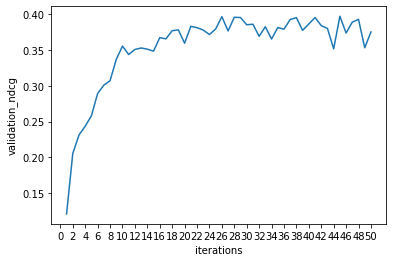

In [ ]:
def train_base_recommendation():
    losses_all=[]
    ndcgs=[]
    if gpu:
        device = torch.device('cuda:%s' % cuda)
    else:
        device = 'cpu'
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path,dataset + "_dataset_obj.pickle"), 'wb') as outp:
    #     pickle.dump(rec_dataset, outp, pickle.HIGHEST_PROTOCOL)

    train_loader = DataLoader(dataset=UserItemInterDataset(rec_dataset.training_data, 
                                rec_dataset.user_feature_matrix, 
                                rec_dataset.item_feature_matrix),
                          batch_size=batch_size,
                          shuffle=True)

    model = BaseRecModel(rec_dataset.feature_num).to(device)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    out_path = os.path.join("./logs", dataset + "_logs")
    Path(out_path).mkdir(parents=True, exist_ok=True)

    ndcg = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('init ndcg:', ndcg)
    for epoch in tqdm.trange(epochs):
        model.train()
        optimizer.zero_grad()
        losses = []
        # print(len(train_loader))
        for user_behaviour_feature, item_aspect_feature, label in train_loader:
            user_behaviour_feature = user_behaviour_feature.to(device)
            item_aspect_feature = item_aspect_feature.to(device)
            label = label.float().to(device)
            out = model(user_behaviour_feature, item_aspect_feature).squeeze()
            if len(out.size())==0:
              continue
            # print(user_behaviour_feature)
            # print( item_aspect_feature)
            loss = loss_fn(out, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.to('cpu').detach().numpy())
            ave_train = np.mean(np.array(losses))
            losses_all.append(ave_train)
        print('epoch %d: ' % epoch, 'training loss: ', ave_train)
      
        # compute necg
        if epoch % 10 == 0:
            ndcg = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
            print('epoch %d: ' % epoch, 'training loss: ', ave_train, 'NDCG_validation: ', ndcg)

            ndcgs.append(ndcg)
    torch.save(model.state_dict(), os.path.join(save_path, "model4.model"))
    ndcg_test = compute_ndcg(rec_dataset.test_data, 
            rec_dataset.user_feature_matrix, 
            rec_dataset.item_feature_matrix, 
            rec_k, 
            model, 
            device)
    print('\nndcg_test: ',ndcg_test)
    # plt.xlabel('iterations')
    # plt.ylabel('train_loss')
    # plt.xticks(np.arange(0,len(losses_all),100))
    # plt.plot(np.arange(0,len(losses_all)),losses_all)
    # plt.show()

    plt.xlabel('iterations')
    plt.ylabel('validation_ndcg')
    plt.xticks(np.arange(-2,len(ndcgs)+2,2))
    plt.plot(np.arange(1,len(ndcgs)+1),ndcgs)
    plt.show()
    return rec_dataset


if __name__ == "__main__":
    torch.manual_seed(0)
    np.random.seed(0)
    if gpu:
        os.environ["CUDA_VISIBLE_DEVICES"] =cuda
        print("Using CUDA",cuda)
    else:
        print("Using CPU")
    rec_dataset=train_base_recommendation()

In [ ]:
dataset="cell_phones"
base_model_path="/content/drive/MyDrive/cell_phone/"
gpu=True
cuda='0'
data_obj_path="/content/drive/MyDrive/cell_phone/"
rec_k=5
lam=100
gam=0.7
alp=0.2
user_mask=False
lr=0.4
step=2000
mask_thresh=0.3
test_num=-1
# save_path="./explanation_objs/"

In [ ]:
import torch
import pickle
import os
from pathlib import Path

# User Perspective Features

In [ ]:
import json
import nltk

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
def lemmatization(text):
    result=''
    wordnet = WordNetLemmatizer()
    for token,tag in pos_tag(text):
        pos=tag[0].lower()
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
        # if pos in ['n','a']:   
        result+=wordnet.lemmatize(token,pos)+' '
    return result
def remove_stopwords(text):
    en_stopwords = stopwords.words('english')
    en_stopwords+=['may','could','that','without','iii','with','and','This','That','Those','These','the','The','brbr','so','it','such']
    result = []
    for token in text:
        if token not in en_stopwords:
            result.append(token)
            
    return result
def remove_punct(text):
    tokenizer = RegexpTokenizer(r"\w+")
    lst=tokenizer.tokenize(' '.join(text))
    return lst

def remove_tag(text):
    text=' '.join(text)
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def preprocess(text):
  chars=['&','%','#','@','^','>','<','\n','\\','\t',';','"','/']
  stwords=stopwords.words('english')
  for ch in chars:
    text=text.replace(ch,' ')
  text=" ".join(text.split())
  # text=text.lower()
  text_tokenized=word_tokenize(text)
  cleaned_text= remove_stopwords(text_tokenized)
  cleaned_text= remove_punct(cleaned_text)
  # cleaned_text=lemmatization(cleaned_text)
  cleaned_text=remove_tag(cleaned_text)
  cleaned_text=remove_urls(cleaned_text)
  cleaned_text=''.join([i for i in cleaned_text ])
  cleaned_text=[word for word in cleaned_text.split(' ') if len(word)>1]
  # print(cleaned_text)
  return ' '.join(cleaned_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
def preprocess_text_first(text):
  while '<' in text and '>' in text and text.index('<')<text.index('>'):
    toRemove=text[int(text.index('<')):int(text.index('>'))]+'>'
    text=text.replace(toRemove,' ')
  list_to_replace=['mso','gte','xml','false','#',',','!','-','\'','\"','[',']','/','\\n','\\','span','a-size-base','a-color-secondary','input type','header name','value','=','<a href= javascript:void(0) class= ','{','}','class=','header','<a href= javascript:void(0)','<','>','href',')','(',';','quot','&',':','javascript']
  for char in list_to_replace:
    text=text.replace(char,' ')
  for i in range(15):
    text=text.replace('  ',' ')
  # while 'if' in text and 'endif' in text and text.index('if')<text.index('endif'):
  #   # print(int(text.index('if')),int(text.index('endif')))
  #   toRemove=text[int(text.index('if')):int(text.index('endif'))]+'endif'
  #   text=text.replace(toRemove,' ')
  new_text=''
  for word in text.split(' '):
    if len(word)>1 and len(word)<35:
      new_text+=word+' '
  # new_text=lemmatization(new_text)
  # print(new_text)
  return new_text

In [ ]:
items_list1=[]
users_list=[]
review_features={}
f=open(save_path+'Cell_Phones_and_Accessories')
lines=f.readlines()
i=0
for line in lines:
  if i%5000==0:
    print(i)
  i+=1
  user_id = line.split('@')[0]
  item_id = line.split('@')[1]
  if item_id in items_list:
    users_list.append(user_id)
    items_list1.append(item_id)
    l = len(user_id) + len(item_id)
    fosr_data = line[l+3:]
    for seg in fosr_data.split('||'):
      if (user_id,item_id) not in review_features.keys():
        review_features[(user_id,item_id)]=[]
      fos = seg.split(':')[0].strip('|')
      if len(fos.split('|')) > 1:
            feature = fos.split('|')[0]
            opinion = fos.split('|')[1]
            sentiment = fos.split('|')[2]
            sentence= seg.split(':')[1]
            if sentiment=='+1':
              senti=1
            else:
              senti=-1
            review_features[(user_id,item_id)].append([feature,opinion,senti,sentence])

0
5000
10000
15000
20000
25000
30000
35000


In [ ]:
user_test_perspective={}
i=0
for (user_id , item_id) in review_features.keys():
  review_feature=review_features[(user_id,item_id)]
  if i%5000==0:
    print(i)
  i+=1
  for features in review_feature:
    sentence=features[3]
    sentence=preprocess_text_first(sentence)
    sentence=preprocess(sentence).lower()
    if (user_id , item_id) not in user_test_perspective.keys():
      final_vect=[]
    final_vect+=sentence.split(' ')
    for word in sentence.split(' '):
      # tokens=list(set(df_words[df_words['word']==word]['tokenized'].values))
      # for token in tokens:
        final_vect+=word.split(' ')
    final_vect=list(set(final_vect))
    new_final_vect=[]
    for word in final_vect:
      if len(word)>1:
        new_final_vect.append(word)
    user_test_perspective[(user_id , item_id)]=new_final_vect

0
5000
10000
15000


In [ ]:
user_test_perspective

In [ ]:
rec_dataset.inv_item_name_dict[622]

'B00FL6ADNC'

# Train Explaination Generator Model


In [ ]:
temp_min =1.0
ANNEAL_RATE = 0.00003
class ExpOptimizationModel(torch.nn.Module):
    def __init__(self, base_model, rec_dataset, device):
        super(ExpOptimizationModel, self).__init__()
        self.base_model = base_model
        self.rec_dataset = rec_dataset
        self.device = device
        self.u_i_exp_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        self.user_feature_matrix = torch.from_numpy(self.rec_dataset.user_feature_matrix).to(self.device)
        self.item_feature_matrix = torch.from_numpy(self.rec_dataset.item_feature_matrix).to(self.device)
        self.rec_dict, self.user_perspective_test_data = self.generate_rec_dict()
        self.dict_items_cf_feature={}

    def generate_rec_dict(self):
        rec_dict = {}
        correct_rec_dict = {}  # used for user-side evaluation
        for row in self.rec_dataset.test_data:
            user = row[0]
            items = row[1]
            labels = row[2]
            # print(labels)
            # print(items)
            correct_rec_dict[user] = []
            user_features = self.user_feature_matrix[user].repeat(len(items), 1)
            scores = self.base_model(user_features,
                        self.item_feature_matrix[items]).squeeze()
            scores = np.array(scores.to('cpu'))
            sort_index = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
            
            sorted_items = [items[i] for i in sort_index]
            # print(sorted_items)
            # print(np.sort(scores))
            rec_dict[user] = sorted_items
            for i in range(rec_k):  # find the correct items and add to the user side test data
                if labels[sort_index[i]] == 1:
                    correct_rec_dict[user].append(items[sort_index[i]])

        user_perspective_test_data = {}  # {(u, i):f, (u, i): f]}
        # for user, items in correct_rec_dict.items():
        #     for item in items:
        #         user_id=rec_dataset.inv_user_name_dict[user]
        #         item_id=rec_dataset.inv_item_name_dict[item]
        #         feature = user_test_perspective[(user_id, item_id)]
        #         user_perspective_test_data[(user, item)] = feature
        return rec_dict, user_perspective_test_data
    def user_side_evaluation(self):
        ave_pre, ave_rec, ave_f1 = evaluate_user_perspective(self.user_perspective_test_data, self.u_i_exp_dict)
        print('user\'s perspective:')
        print('ave pre: ', ave_pre, '  ave rec: ', ave_rec, '  ave f1: ', ave_f1)
        return ave_pre,ave_rec,ave_f1
    
    def model_side_evaluation(self):
        ave_pn, ave_ps, ave_fns = evaluate_model_perspective(
            self.rec_dict,
            self.u_i_exp_dict,
            self.base_model,
            self.rec_dataset.user_feature_matrix,
            self.rec_dataset.item_feature_matrix,
            rec_k,
            self.dict_items_cf_feature,
            self.device)
        print('model\'s perspective:')
        print('ave PN: ', ave_pn, '  ave PS: ', ave_ps, '  ave F_{NS}: ', ave_fns)  
        return ave_pn , ave_ps , ave_fns
    def generate_explanation(self,lr,temp,a,b,c):
        # u_i_exps_dict = {}  # {(user, item): [f1, f2, f3 ...], ...}
        exp_nums = []
        exp_complexities = []
        self.no_exp_count = 0
        self.exp_count=0
        if test_num == -1:
            test_num1 = len(list(self.rec_dict.items()))
        else:
            test_num1 = test_num
        count=0
        for user, items in tqdm.tqdm(list(self.rec_dict.items())[:10]):
            count+=1
            # if count<200:
            #   continue
            # if count==2:
            #   break
            items = self.rec_dict[user]
            margin_item = items[rec_k]
            margin_score = self.base_model(self.user_feature_matrix[user].unsqueeze(0), 
                            self.item_feature_matrix[margin_item].unsqueeze(0)).squeeze()
            # print(margin_score)
            # if user_mask:
            #     # mask_vec = self.generate_mask(user)
            #     mask_vec = torch.where(self.user_feature_matrix[user]>0, 1., 0.).unsqueeze(0)  # only choose exps from the user cared aspects
            # else:
                
            for item in items[: rec_k]:
                if item in rec_dataset.inv_item_name_dict.keys():
                  item_id=rec_dataset.inv_item_name_dict[item]
            
                  tensor_vect_desc,tensor_vect_title,tensor_vect_feature=get_tensor_vects(item_id)
                  self.dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title,tensor_vect_feature)
                  # print(tensor_vect_desc.shape)
                  # print(tensor_vect_title.shape)
                  # print(tensor_vect_feature.shape)
                  # feature_length,features=get_features(item)
                  # replaced_words,replaced_vects,logits_tensor,words_indices=get_replaced_words_vects(rec_dataset.inv_item_name_dict[item])
                  # print(len(words_indices) ,len(features))

                  explanation_features_words,explanation_features_words_replaced, exp_num = self.explain(user,item,
                      self.user_feature_matrix[user], 
                      self.item_feature_matrix[item], 
                      margin_score,
                      tensor_vect_desc,tensor_vect_title,tensor_vect_feature,lr, temp,a,b,c)
                  
                  if explanation_features_words==None or len(explanation_features_words)==0:
                      # print('no explanation for user %d and item %d' % (user, item))
                      self.no_exp_count += 1
                  else:
                      self.exp_count+=1
                      self.u_i_exp_dict[(user, item)] = (explanation_features_words,explanation_features_words_replaced)
                      # print(explanation_features_words)
                      exp_nums.append(exp_num)
              
                    # exp_complexities.append(exp_complexity)
            # if count%500==0:
            #   json1 = json.dumps(self.u_i_exp_dict)
            #   f = open("drive/MyDrive/ranjbar/dict{}.json".format(count),"w")
            #   f.write(json1)
            #   f.close()

              
        print('ave num: ', np.mean(exp_nums),  'no_exp_count: ', self.no_exp_count, 'exp_count: ', self.exp_count)
        return  np.mean(exp_nums), self.no_exp_count,  self.exp_count
    
    def explain(self,user,item, user_feature, item_feature, margin_score,tensor_vect_desc,tensor_vect_title,tensor_vect_feature , lr, temp,a, b, c):
        self.exp_generator = EXPGenerator(
            self.rec_dataset, 
            self.base_model, 
            user_feature, 
            item_feature, 
            user,
            item,
            margin_score,
            tensor_vect_desc,tensor_vect_title, tensor_vect_feature,
            self.device).to(self.device)
        # optimization
        optimizer = torch.optim.SGD(self.exp_generator.parameters(), lr=lr, weight_decay=0)
        self.exp_generator.train()
        lowest_loss = None
        lowest_bpr = None
        optimize_pi = None
        # temp=1.0
        score = self.exp_generator(temp)
        # print(score)
        bpr, l1,prob_loss, loss = self.exp_generator.loss(a,b,c,score)
        # print('init: ', 0, '  train loss: ', loss, '  bpr: ', bpr, '  l2: ', l2, '  l1: ', l1)
        lowest_loss = loss
        lowest_bpr=bpr
        optimize_pi = self.exp_generator.pi
        for epoch in range(step):
            self.exp_generator.zero_grad()
            score = self.exp_generator(temp)
            bpr, l1,prob_loss, loss = self.exp_generator.loss(a,b,c,score)
            if epoch %10==0:
               temp = np.minimum(temp * np.exp(-ANNEAL_RATE * epoch), temp)
            # if epoch %100 == 0:
            #    print(
            #         'temp',temp,
            #         'epoch', epoch,
            #         'bpr: ', bpr,
            #         'loss', loss,
            #         'prob_loss', prob_loss,
            #          'l1',l1
            #          )

            loss.backward(retain_graph=True)
            # bpr.backward(retain_graph=True)
            # l1.backward(retain_graph=True)

            optimizer.step()
            if loss < lowest_loss:
                lowest_loss = loss
                lowest_bpr = bpr
                optimize_pi =self.exp_generator.pi
        # print(lowest_bpr)
        # print(lam * alp)
        # print(optimize_delta)
        if lowest_bpr >= a * alp:
            explanation_features = None 
            exp_num = None
            exp_complexity = None
            explanation_features_words=None
            explanation_features_words_replaced=None
        else:
            # optimize_delta = exp_generator.delta.detach().to('cpu').numpy()
            # print(optimize_delta)
            # explanation_features = np.argwhere(optimize_delta < - mask_thresh).squeeze(axis=1)
            main_features=self.exp_generator.features
            new_features_inds=torch.argmax(optimize_pi,axis=1)
            # print(torch.sort(optimize_pi))
            # print(torch.sort(exp_generator.pi))
            # print(torch.sort(exp_generator.main_pi))
            new_features=[self.exp_generator.replaced_words[i] for i in new_features_inds]
            # print(main_features)
            # print(new_features)
            explanation_features_words= [main_features[i] for i in range(len(main_features)) if main_features[i] != new_features[i]]
            explanation_features_words_replaced=[new_features[i] for i in range(len(main_features)) if main_features[i] != new_features[i]]
            # print([main_features[i].tolist() for i in explanation_features_inds[0]])
            # print(new_features[explanation_features_inds[0]])
            # print(main_features[explanation_features_inds[0]])
            
            # explanation_features_words=main_features[explanation_features_inds[0]]
            # print(explanation_features_words)
            # print(explanation_features_words_replaced)
            # print('-------------\n')
            new_vect=[]
            for word in explanation_features_words:
              new_vect+=(str(word).split(' '))
            new_vect=list(set(new_vect))
            new_vect=[word for word in new_vect if len(word)>1]
            explanation_features_words=new_vect
            exp_num = len(explanation_features_words)
            # exp_complexity = lowest_l2.to('cpu').detach().numpy() + gam * exp_num
        return explanation_features_words,explanation_features_words_replaced, exp_num
    


In [ ]:
def get_tensor_vect_df(df,not_in_columns):
  df['main_word']=np.where(df['replaced_word'] == df[not_in_columns],1,0)
  df=df[df['main_word']==1]
  lists=df.loc[:, ~df.columns.isin([not_in_columns,'replaced_word','logit','main_word'])].values
  words=df[not_in_columns].values
  # print(words)
  vects=[sub_list[0] for sub_list in lists]
  tensor_vect=torch.FloatTensor(vects).to(device)
  return tensor_vect

In [ ]:
def get_tensor_vects(item_id):
  tensor_vect_desc=None
  tensor_vect_title=None
  tensor_vect_feature=None
  # print(item_id)
  if os.path.exists(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id)) :
    df_vect_desc= pd.read_json(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id))
    # df_vect_desc=df_vect[0]
    tensor_vect_desc=get_tensor_vect_df(df_vect_desc,'description_words')

    df_vect_title= pd.read_json(save_path+'title_bert/'+'df_bert_title_{}.json'.format(item_id))
    # df_vect_title=df_vect[1]
    tensor_vect_title=get_tensor_vect_df(df_vect_title,'title_words')

    df_vect_feature= pd.read_json(save_path+'feature_bert/'+'df_bert_feature_{}.json'.format(item_id))
    # # df_vect_feature=df_vect[2]
    tensor_vect_feature=get_tensor_vect_df(df_vect_feature,'feature_words')
  # print(tensor_vect_feature)
  return tensor_vect_desc,tensor_vect_title,tensor_vect_feature

In [ ]:
rec_dataset.inv_item_name_dict

In [ ]:
def get_features(item):
  item_features=rec_dataset.item_features[item]
  len_features=0
  features=[]
  for i in range(3):
    len_features+=len(item_features[i])
    features+=item_features[i]
  # for key in item_features[3]:
  #   len_features+=len(item_features[3][key])
  #   features+=item_features[3][key]
  # features+=item_features[3]
  # len_features+=1
  # print(len_features)
  # print(features)
  return len_features,features

In [ ]:
def get_average_vect_test(weights,tensor_vect):
  # weights=torch.FloatTensor(weights).to(device)
  weights=torch.transpose(weights.repeat(tensor_vect.shape[1],1),0,1)
  average=torch.mean(weights*tensor_vect,axis=0).to(device)
  return average

In [ ]:
def get_new_item_vector2(item,item_feature_name,new_weights,tensor_vect_desc,tensor_vect_title,tensor_vect_feature):
    # item_id= rec_dataset.inv_item_name_dict[item]
    final_vector=[]
    # print(len(new_weights))
    # print(len(item_feature_name[0]))
    # print(tensor_vect_desc.shape)
    average_vect_desc=get_average_vect_test(new_weights[0:len(item_feature_name[0])],tensor_vect_desc)
    average_vect_title=get_average_vect_test(new_weights[len(item_feature_name[0]):len(item_feature_name[0])+len(item_feature_name[1])],tensor_vect_title)
    average_vect_feature=get_average_vect_test(new_weights[len(item_feature_name[0])+len(item_feature_name[1]):],tensor_vect_feature)
    # rank=normalized_rank[item_id]*new_weights[-1]
    final_vector=torch.cat((average_vect_desc,average_vect_title,average_vect_feature))
    # print(len(final_vector))
    # final_vect=np.array(final_vector, dtype='float32')
    return final_vector

In [ ]:
def get_new_item_vector(replaced_vects,item,item_feature_name,pi):
    # print(pi.shape)
    # print(replaced_vects)
    # print(pi)
    final_vector=torch.mm(pi,replaced_vects)
    desc_vect=final_vector[0:len(item_feature_name[0])]
    # print(desc_vect.shape)
    title_vect=final_vector[len(item_feature_name[0]):len(item_feature_name[0])+len(item_feature_name[1])]
    features_vect=final_vector[len(item_feature_name[0])+len(item_feature_name[1]):]
    if len(title_vect)>0:
      average_title=torch.mean(title_vect,axis=0).to(device)
    else:
      average_title=torch.zeros(768).to(device)
    if len(features_vect)>0:  
      average_features=torch.mean(features_vect,axis=0).to(device)
    else:
      average_features=torch.zeros(768).to(device)
    if len(desc_vect)>0:
      average_descriptions=torch.mean(desc_vect,axis=0).to(device)
    else:
      average_descriptions=torch.zeros(768).to(device)
    final_vector=torch.cat((average_descriptions,average_title,average_features))
    # print(final_vector)
    # final_vect=np.array(final_vector, dtype='float32')
    return final_vector

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.9 MB/s eta 0:00:00


In [ ]:
from transformers import AutoConfig, AutoTokenizer, AutoModel
import torch
config = AutoConfig.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_initialized_teta(features,len_words,words_indices,val):
  init_teta=torch.zeros(len(features), len_words)
  indices = torch.arange(init_teta.size(0)).long()
  init_teta[indices, torch.LongTensor(words_indices)] =val
  init_teta = init_teta.to(device)
  init_teta.requires_grad = True
  return init_teta

In [ ]:
def get_all_logits(len_features,df_desc,df_title, df_feature,main_words):
  len_words=len(main_words[0])+len(main_words[1])+len(main_words[2])
  all_logits=np.zeros((len_words,len_features))
  j=0
  len_desc=0
  for i, row in df_desc.iterrows():
    len_desc+=1
    if row['description_words'] != main_words[0][j]:
      j+=1
    all_logits[j][i]=row['logit']
  
  k=j+1
  j=0
  len_title=0
  for i, row in df_title.iterrows():
    len_title+=1
    if row['title_words'] != main_words[1][j]:
      k+=1
      j+=1
    all_logits[k][i+len_desc]=row['logit']

  j=0
  k+=1
  for i, row in df_feature.iterrows():
    if row['feature_words']!= main_words[2][j]:
      k+=1
      j+=1
    all_logits[k][i+len_desc+len_title]=row['logit']

  # print(all_logits[-4])
  return all_logits

In [ ]:
def get_replaced_words_vects(item_id):
    replaced_words=[]
    replaced_logits=[]
    replaced_vects=[]
    words_indices=[]
    main_words=[]
    final_logits_tensor=[]
    i=0
    # print(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id))
    if os.path.exists(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id)):
      df_vect_desc_item= pd.read_json(save_path+'description_bert/'+'df_bert_desc_{}.json'.format(item_id))
      df_vect_title_item= pd.read_json(save_path+'title_bert/'+'df_bert_title_{}.json'.format(item_id))
      df_vect_feature_item= pd.read_json(save_path+'feature_bert/'+'df_bert_feature_{}.json'.format(item_id))

      replaced_words_desc=df_vect_desc_item['replaced_word'].values
      replaced_words_title=df_vect_title_item['replaced_word'].values
      replaced_words_feature=df_vect_feature_item['replaced_word'].values

      vects_desc=df_vect_desc_item['description_vects'].values
      vects_title=df_vect_title_item['title_vects'].values
      vects_feature=df_vect_feature_item['feature_vects'].values

      replaced_words=list(replaced_words_desc)
      replaced_words+=list(replaced_words_title)
      replaced_words+=list(replaced_words_feature)

      vects1=[sub_list for sub_list in  vects_desc]
      replaced_vects=vects1
      vects2=[sub_list for sub_list in  vects_title]
      replaced_vects+=vects2
      vects3=[sub_list for sub_list in  vects_feature]
      replaced_vects+=vects3
      replaced_vects=torch.FloatTensor(replaced_vects).to(device)

      df_vect_desc_item['main_word']=np.where(df_vect_desc_item['replaced_word'] == df_vect_desc_item['description_words'],1,0)
      indexes=df_vect_desc_item[df_vect_desc_item['main_word']==1].index
      main_words.append(list(df_vect_desc_item[df_vect_desc_item['main_word']==1]['description_words'].values))
      for ind in indexes:
        words_indices.append(i+ind)
      i=df_vect_desc_item.shape[0]

      df_vect_title_item['main_word']=np.where(df_vect_title_item['replaced_word'] == df_vect_title_item['title_words'],1,0)
      indexes=df_vect_title_item[df_vect_title_item['main_word']==1].index
      main_words.append(list(df_vect_title_item[df_vect_title_item['main_word']==1]['title_words'].values))
      for ind in indexes:
        words_indices.append(i+ind)
      i=df_vect_desc_item.shape[0]+df_vect_title_item.shape[0]

      df_vect_feature_item['main_word']=np.where(df_vect_feature_item['replaced_word'] == df_vect_feature_item['feature_words'],1,0)
      indexes=df_vect_feature_item[df_vect_feature_item['main_word']==1].index
      main_words.append(list(df_vect_feature_item[df_vect_feature_item['main_word']==1]['feature_words'].values))
      for ind in indexes:
        words_indices.append(i+ind)
      
      # print(item_id)
      # print(main_words)
      # print(replaced_words)
      # print(words_indices)
      # flatList = [ item for elem in main_words for item in elem]
      # i=0
      # for ind in words_indices:
      #   print(flatList[i],replaced_words[ind])
      #   i+=1
      # print(len(replaced_words))
      # print(len(words_indices))
      replaced_logits= get_all_logits(len(replaced_words),df_vect_desc_item,df_vect_title_item, df_vect_feature_item,main_words)
      final_logits_tensor=torch.FloatTensor(replaced_logits).to(device)
    return replaced_words,replaced_vects,final_logits_tensor,words_indices

In [ ]:
q =[[0,1,2],[3,0,4],[5,6,0]]
tense_tensor = torch.tensor(q)
print(torch.where(tense_tensor==0,torch.tensor(-1),tense_tensor))

tensor([[-1,  1,  2],
        [ 3, -1,  4],
        [ 5,  6, -1]])


In [ ]:
class EXPGenerator(torch.nn.Module):
    def __init__(self, rec_dataset, base_model, user_vect, item_vect,user,item, margin_score,tensor_vect_desc,tensor_vect_title,tensor_vect_feature, device):
        super(EXPGenerator, self).__init__()
        self.rec_dataset = rec_dataset
        self.base_model = base_model
        self.user_vect = user_vect
        self.item_vect= item_vect
        self.margin_score = margin_score
        self.device = device
        self.feature_length,self.features=get_features(item)
        self.item=item
        self.user=user
        self.replaced_words,self.replaced_vects,self.logits_tensor,self.words_indices=get_replaced_words_vects(rec_dataset.inv_item_name_dict[item])
        self.logits_tensor=torch.where(self.logits_tensor==12.0,torch.tensor(-0.1).to(device),self.logits_tensor).to(device)
        self.logits_tensor=torch.where(self.logits_tensor==5.0,torch.tensor(-0.1).to(device),self.logits_tensor).to(device)
        self.logits_tensor=torch.where(self.logits_tensor==0.0,torch.tensor(-1.0).to(device),self.logits_tensor).to(device)
        # print(self.logits_tensor)
        # self.feature_range = [0, 1]  # hard coded, should be improved later
        # print(self.features)
        teta_par=get_initialized_teta(self.features,len(self.replaced_words),self.words_indices,12.0)
        # print(torch.sort(teta_par))
        self.teta =  torch.nn.Parameter(teta_par)
        
        self.main_pi = F.softmax((self.teta + self.sample_gumbel((self.feature_length,len(self.replaced_words)))) /0.000000000001, dim=-1)
        # self.main_pi=torch.clamp((self.teta), 0,1)
        # print(self.features)
        self.item=item
        self.user=user
        self.tensor_vect_desc=tensor_vect_desc
        self.tensor_vect_title=tensor_vect_title
        self.tensor_vect_feature=tensor_vect_feature
    
    def get_masked_item_feature(self,temp):
        item_feature_name=self.rec_dataset.item_features[self.item]
        self.pi = F.softmax((self.teta + self.sample_gumbel((self.feature_length,len(self.replaced_words)))) /temp, dim=-1)
        # print(self.teta)
        # print(self.pi)
        # self.pi=torch.clamp((self.teta), 0,1)
        # print(self.pi)
        item_feature_star=get_new_item_vector(self.replaced_vects,self.item,item_feature_name,self.pi)
        # print(item_feature_star)
        return item_feature_star

    def sample_gumbel(self,shape, eps=1e-20):
      U = torch.rand(shape)
      U = U.cuda()
      return -torch.log(-torch.log(U + eps) + eps)
    
    def forward(self,temp):
        item_feature_star = self.get_masked_item_feature(temp)
        # print(item_feature_star.unsqueeze(0).shape)
        # print(self.user_vect.unsqueeze(0).shape)
        score = self.base_model(self.user_vect.unsqueeze(0), item_feature_star.unsqueeze(0))
        # print(score)
        return score
    
    def loss(self, a,b,c, score):
        # print(self.margin_score)
        # print(score)
        # print(torch.sort(self.pi))
        bpr = torch.nn.functional.relu(alp + score - self.margin_score) * a
        l1 = torch.linalg.norm(self.main_pi-self.pi,ord=1)*b
        prob_loss= ((1.0/torch.tensordot(self.pi,self.logits_tensor))*c)
        loss = prob_loss + l1 + bpr
        return bpr, l1,prob_loss, loss

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj_4.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
user_test_perspective

In [ ]:
def evaluate_user_perspective(user_perspective_data, u_i_expl_dict):
    pres = []
    recs = []
    f1s = []
    for u_i, gt_features in user_perspective_data.items():
        if u_i in u_i_expl_dict:
            TP = 0
            pre_features = u_i_expl_dict[u_i][0]
            # print('f: ', gt_features, pre_features)
            for feature in pre_features:
                if feature in gt_features:
                    TP += 1
            # print(gt_features)
            # print(pre_features)
            pre = TP / len(pre_features)
            rec = TP / len(gt_features)
            if (pre + rec) != 0:
                f1 = (2 * pre * rec) / (pre + rec)
            else:
                f1 = 0
            pres.append(pre)
            recs.append(rec)
            f1s.append(f1)
    ave_pre = np.mean(pres)
    ave_rec = np.mean(recs)
    ave_f1 = np.mean(f1s)
    return ave_pre, ave_rec, ave_f1

In [ ]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
def sample_gumbel(shape, eps=1e-20):
      U = torch.rand(shape)
      U = U.cuda()
      return -torch.log(-torch.log(U + eps) + eps)
def evaluate_model_perspective(
        rec_dict,
        u_i_exp_dict,
        base_model,
        user_feature_matrix,
        item_feature_matrix,
        rec_k,
        dict_items_cf_feature,
        device):
    """
    compute PN, PS and F_NS score for the explanations
    :param rec_dict: {u1: [i1, i2, i3, ...] , u2: [i1, i2, i3, ...]}
    :param u_i_exp_dict: {(u, i): [f1, f2, ...], ...}
    :param base_model: the trained base recommendation model
    :param user_feature_matrix: |u| x |p| matrix, the attention on each feature p for each user u
    :param item_feature_matrix: |i| x |p| matrix, the quality on each feature p for each item i
    :param rec_k: the length of the recommendation list, only generated explanations for the items on the list
    :param device: the device of the model
    :return: the mean of the PN, PS and FNS scores
    """
    pn_count = 0
    ps_count = 0
    # df_vects=rec_dataset.df_vects
    # print(len( u_i_exp_dict))
    i=0
    count_all=0
    dict_items={}
    for u_i, fs in u_i_exp_dict.items():
        # if i%100==0:
        #   print(i)
        # i+=1
        # if i>15600 and i<16000: 
        #   continue
        count_all+=1
        user = u_i[0]
        target_item = u_i[1]
        features = fs[0]
        replaced_features=fs[1]
        items = rec_dict[user]
        target_index = items.index(target_item)
        features=list(set(features))
        
        # print(len(items))

        # compute PN
        cf_items_features1 = []
        cf_items_features2 = []
        for item in items:
          # if item in dict_items.keys():
          #   replaced_words,replaced_vects,logits_tensor,words_indices=dict_items.get(item)
          # else:
          #   replaced_words,replaced_vects,logits_tensor,words_indices=get_replaced_words_vects(rec_dataset.inv_item_name_dict[item])
          #   dict_items[item]=(replaced_words,replaced_vects,logits_tensor,words_indices)

          # item_id=rec_dataset.inv_item_name_dict[item]
          # item_cf_feature1,item_cf_feature2=get_item_vector1(item,features,replaced_words,replaced_vects,logits_tensor,words_indices)
  
          # cf_items_features1.append(item_cf_feature1)
          # cf_items_features2.append(item_cf_feature2)
            item_id=rec_dataset.inv_item_name_dict[item]
            len_features,all_features=get_features(item)
            # print(all_features)
            # print(features)
            item_feature_name=rec_dataset.item_features[item]
            weights1=[0.0 if fea in features else 1.0 for fea in all_features]
            weights2=[1.0 if fea in features else 0.0 for fea in all_features]
            weights1=torch.from_numpy(np.array(weights1,dtype='float32')).to(device)
            weights2=torch.from_numpy(np.array(weights2,dtype='float32')).to(device)
            # print(len(all_features))
            # print(all_features)
            # weights=torch.FloatTensor(weights).to(device)
            if item in dict_items_cf_feature.keys():
              tensor_vect_desc,tensor_vect_title,tensor_vect_feature=dict_items_cf_feature[item]
            else:
              tensor_vect_desc,tensor_vect_title,tensor_vect_feature=get_tensor_vects(item_id)
              dict_items_cf_feature[item]=(tensor_vect_desc,tensor_vect_title,tensor_vect_feature)
            
            item_cf_feature1=get_new_item_vector2(item,item_feature_name,weights1,tensor_vect_desc,tensor_vect_title,tensor_vect_feature).detach().to('cpu').numpy()
            item_cf_feature2=get_new_item_vector2(item,item_feature_name,weights2,tensor_vect_desc,tensor_vect_title,tensor_vect_feature).detach().to('cpu').numpy()
            cf_items_features1.append(item_cf_feature1)
            cf_items_features2.append(item_cf_feature2)

        cf_ranking_scores1 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features1))])
                                                            ).to(device),
                                           torch.from_numpy(np.array(cf_items_features1,dtype='float32')).to(device)).squeeze()
        cf_score_list1 = cf_ranking_scores1.to('cpu').detach().numpy()
        # print(np.sort( cf_score_list1)[::-1])
        sorted_index1 = np.argsort(cf_score_list1)[::-1]
        # print(sorted_index1)
        cf_rank1 = np.argwhere(sorted_index1 == target_index)[0, 0]  # the updated ranking of the current item
        # print(cf_rank1)
        if cf_rank1 > rec_k - 1:
            pn_count += 1
        # compute NS
        cf_ranking_scores2 = base_model(torch.from_numpy(np.array([user_feature_matrix[user]
                                                                      for i in range(len(cf_items_features2))])
                                                            ).to(device),
                                           torch.from_numpy(np.array(cf_items_features2,dtype='float32')).to(device)).squeeze()
        cf_score_list2 = cf_ranking_scores2.to('cpu').detach().numpy()
        sorted_index2 = np.argsort(cf_score_list2)[::-1]
        cf_rank2 = np.argwhere(sorted_index2 == target_index)[0, 0]  # the updated ranking of the current item
        if cf_rank2 < rec_k:
            ps_count += 1
    if len(u_i_exp_dict) != 0:
        pn = pn_count / count_all
        ps = ps_count / count_all
        if (pn + ps) != 0:
            fns = (2 * pn * ps) / (pn + ps)
        else:
            fns = 0
    else:
        pn = 0
        ps = 0
        fns = 0
    return pn, ps, fns

In [ ]:
with open(os.path.join(data_obj_path, dataset + "_dataset_obj_Gumbel.pickle"), 'rb') as inp:
   rec_dataset = pickle.load(inp)

In [ ]:
def get_item_vector1(item,features, replaced_words,replaced_vects,logits_tensor,words_indices):
    all_features=[replaced_words[ind] for ind in words_indices]
    words_indices_new1=[words_indices[i] for i in range(len(words_indices)) if all_features[i] not in features]
    # print(all_features)
    # print([replaced_words[ind] for ind in words_indices_new1])
    words_indices_new2=[words_indices[i] for i in range(len(words_indices)) if all_features[i] in features]
    # print([replaced_words[ind] for ind in words_indices_new2])
    teta_par1=get_initialized_teta(words_indices_new1,len(replaced_words),words_indices_new1,1.0)

    # pi1 = F.softmax((teta_par1 + sample_gumbel((len(words_indices_new1),len(replaced_words)))) /0.0000001, dim=-1)

    teta_par2=get_initialized_teta(words_indices_new2,len(replaced_words),words_indices_new2,1.0)
    # pi2 = F.softmax((teta_par2 + sample_gumbel((len(words_indices_new2),len(replaced_words)))) /0.0000001, dim=-1)
    
    item_cf_feature1=get_new_item_vector(replaced_vects,item,all_features,teta_par1).detach().to('cpu').numpy()
    item_cf_feature2=get_new_item_vector(replaced_vects,item,all_features,teta_par2).detach().to('cpu').numpy()
    return item_cf_feature1, item_cf_feature2

In [ ]:
def get_item_vector2(item):
  item_cf_feature=rec_dataset.item_feature_matrix[item]
  return item_cf_feature,item_cf_feature

In [ ]:
# result_dict={'lr':[],'temp':[],'l1_b':[],'prob_c':[],'ave_num':[] , 'no_exp_count':[] , 'exp_count':[], 'ave_pre_user':[] ,'ave_rec_user':[], 'ave_f1_user':[] , 'ave_ps_model':[],'ave_pn_model':[],'ave_fNS_model':[]}

In [ ]:
users_list=[]
for i in range(len(rec_dataset.test_data)):
    users_list.append(rec_dataset.inv_user_name_dict[rec_dataset.test_data[i][0]])

In [ ]:
users_list

In [ ]:
items_list=[]
for i in range(10):
  for item in rec_dataset.test_data[i][1]:
    items_list.append(rec_dataset.inv_item_name_dict[item])

In [ ]:
items_list=list(set(items_list))

In [ ]:
def generate_explanation():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    # import dataset
    with open(os.path.join(data_obj_path, dataset + "_dataset_obj_Gumbel.pickle"), 'rb') as inp:
        rec_dataset = pickle.load(inp)
    base_model = BaseRecModel(rec_dataset.feature_num).to(device)
    base_model.load_state_dict(torch.load(os.path.join(base_model_path,"model4.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    # Create optimization model
   
    # lrs=[1.0]
    # temps=[0.5,1.0,1.5]
    a=100.0
    # bs=[1.0,2.0]
    # cs=[1000.0,2000.0,10000.0]
    lrs=[0.1]
    temps=[1.0]
    bs=[2.0]
    cs=[10000.0]
    with open(save_path+'result_validation.txt','w') as result_file:
      for lr in lrs:
        for temp in temps:
          for b in bs:
            for c in cs:
              print('lr:', lr , '   temp:', temp , '   l1_b:', b , '   prob_c:', c)
              opt_model = ExpOptimizationModel(base_model=base_model,rec_dataset=rec_dataset,device = device)
              ave_num,no_exp_count,exp_count=opt_model.generate_explanation(lr,temp,a,b,c)
              # ave_pre,ave_rec,ave_f1=opt_model.user_side_evaluation()
              ave_pn,ave_ps,ave_fns=opt_model.model_side_evaluation()
              # result_file.write(str(lr)+'#'+str(temp)+'#'+str(b)+'#'+str(c)+'#'+str(ave_num)+'#'+str(no_exp_count)+'#'+str(exp_count)+'#'+str(ave_pre)+'#'+str(ave_rec)+'#'+str(ave_f1)+'#'+str(ave_pn)+'#'+str(ave_ps)+'#'+str(ave_fns))
              # result_file.write('\n')
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
    #     pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'rb') as opt:
    #     opt_model = pickle.load(opt)
            
    # print(opt_model.u_i_exp_dict)
    # Path(save_path).mkdir(parents=True, exist_ok=True)
    # with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'wb') as outp:
    #     pickle.dump(opt_model, outp, pickle.HIGHEST_PROTOCOL)
    return opt_model


if __name__ == "__main__":
    opt_model=generate_explanation()

cuda:0
lr: 0.1    temp: 1.0    l1_b: 2.0    prob_c: 10000.0


100%|██████████| 20/20 [14:20<00:00, 43.02s/it]


ave num:  7.771428571428571 no_exp_count:  30 exp_count:  70
model's perspective:
ave PN:  0.9   ave PS:  0.9714285714285714   ave F_{NS}:  0.934351145038168


In [ ]:
with open(os.path.join(save_path, dataset + "_dataset_obj_Gumbel.pickle"), 'rb') as inp:
  rec_datasetG = pickle.load(inp)

In [ ]:
with open(os.path.join(save_path, dataset + "_dataset_obj_4.pickle"), 'rb') as inp:
  rec_dataset = pickle.load(inp)

In [ ]:
review_features[('A3VVMIMMTYQV5F','B00U7YKO78')]

[['plastic', 'back', 1, 'I have a Spigen case that has a clear plastic back'],
 ['charge',
  'quick',
  1,
  "It charged so quick I didn't get the chance to really figure out when it topped off"],
 ['phone', 'right', 1, 'I charged my phone right away to try it out'],
 ['case', 'clear', 1, 'I have a Spigen case that has a clear plastic back'],
 ['case', 'clear', 1, 'My Spigen case was a clear plastic'],
 ['lights', 'blue', 1, 'the blue lights will start blinking'],
 ['lights',
  'blue',
  1,
  'it emits 2 deep blue tubular lights along the front side to let you know\n']]

In [ ]:
user_test_perspective[('A3VVMIMMTYQV5F','B00U7YKO78')]

['start',
 'my',
 'charged',
 'side',
 'figure',
 'away',
 'blue',
 'along',
 'clear',
 'back',
 'blinking',
 'quick',
 'chance',
 'let',
 'it',
 'plastic',
 'really',
 'phone',
 'know',
 'deep',
 'front',
 'topped',
 'get',
 'emits',
 'tubular',
 'case',
 'lights',
 'spigen',
 'try',
 'right']

In [ ]:
review_features[('A1F7YU6O5RU432','B00Z7RQ0NC')]

[['case',
  'pretty',
  1,
  'Love the looks of it and when the sun catches the silver flecks on the case its so pretty'],
 ['case',
  'clear',
  1,
  'The case is clear so whatever color your iPhone is youll be able to see it a bit through the sparkles'],
 ['photos',
  'online',
  -1,
  'What might be hard to tell initially from the online photos is this case has a bunch of gorgeous sparkles inside the clear plastic\n']]

In [ ]:
user_test_perspective[('A1F7YU6O5RU432','B00Z7RQ0NC')]

['iphone',
 'catches',
 'tell',
 'youll',
 'silver',
 'might',
 'whatever',
 'looks',
 'hard',
 'able',
 'flecks',
 'bunch',
 'love',
 'clear',
 'what',
 'sun',
 'plastic',
 'initially',
 'color',
 'gorgeous',
 'photos',
 'online',
 'sparkles',
 'inside',
 'see',
 'case',
 'bit',
 'pretty']

In [ ]:
rec_datasetG.item_name_dict['B00Z7RQ0NC']

1460

In [ ]:
rec_datasetG.user_name_dict['A1F7YU6O5RU432']

57

In [ ]:
opt_model.u_i_exp_dict

{(6, 1311): (['purple', 'protection'], ['and', 'structure', 'for', 'screen']),
 (8, 911): (['blackberry', 'motorola', 'nokia'],
  ['gear', 'construction', 'optional']),
 (8,
  448): (['included',
   'spare',
   'sticker',
   'samsung',
   'portability',
   'battery',
   '2600mah',
   'adapter',
   'galaxy',
   'travel',
   'compact',
   '700mah',
   'discontinued',
   'seconds',
   'charging'], ['galaxy',
   'mobile',
   'down',
   'as',
   'cell',
   'charge',
   'and',
   'turn',
   'charger',
   'your',
   'and',
   'small',
   'charger',
   'complaints',
   'mobile',
   'battery',
   'like']),
 (8, 1480): (['cowabunga', 'gunmetal', 'grey', 'series', 'packaging'],
  ['protection', '-', '.', 'bar', 'also']),
 (50, 1311): (['purple'], ['pockets']),
 (57,
  1449): (['black',
   'limited',
   'alpha',
   'series',
   'leather',
   'retail',
   'packaging',
   'iphone',
   'onyx',
   'otterbox',
   'case'], [',',
   'special',
   ';',
   'camera',
   'windows',
   'and',
   '.',
   '!',


cuda:0
lr: 0.1    temp: 1.0    l1_b: 2.0    prob_c: 10000.0

100%|██████████| 93/93 [1:02:01<00:00, 40.01s/it]

ave num:  9.617728531855956 no_exp_count:  104 exp_count:  361
user's perspective:
ave pre:  0.1103627430177672   ave rec:  0.06848063392516375   ave f1:  0.07372088911510503
model's perspective:
ave PN:  0.9750692520775623   ave PS:  0.9944598337950139   ave F_{NS}:  0.9846690900023767


In [ ]:
lens=[]
for item in rec_dataset.inv_item_name_dict.keys():
  lens.append(get_features(item)[0])

In [ ]:
print(np.average(lens))

165.66185567010308


In [ ]:
15.6/165

0.09454545454545454

In [ ]:
df_vect_desc_item= pd.read_json(save_path+'descriptions_bert/'+'{}.json'.format('B005SUHRH6'))
df_vect_title_item= pd.read_json(save_path+'titles_bert/'+'{}.json'.format('B005SUHRH6'))
df_vect_feature_item= pd.read_json(save_path+'features_bert/'+'{}.json'.format('B005SUHRH6'))

In [ ]:
df_vect_feature_item[50:80]

,logit,replaced_word,feature_words,feature_vects
50,7.369977,plug,usb,"[0.3451986611, -0.047913707800000004, 0.499550..."
51,7.482923,socket,usb,"[0.6237714887, -0.2293379307, 0.03471336140000..."
52,8.356534,connector,usb,"[0.8944671154, -0.23064228890000002, 0.3981048..."
53,11.160816,pins,usb,"[0.42672345040000004, 0.40431830290000004, 0.4..."
54,14.596963,pin,usb,"[0.46698412300000003, -0.3236961067, 0.5272601..."
55,5.000000,usb,usb,"[0.0133157885, -0.1174044833, 0.3586080968, 0...."
56,8.763692,connector,lightning,"[0.6830018163, -0.7294709086000001, 0.04348436..."
57,8.776958,port,lightning,"[-0.2468748987, -0.7753401399000001, 0.2136877..."
58,9.968749,usb,lightning,"[0.14637564120000002, -0.3030876219, 0.3372566..."
59,11.939353,pin,lightning,"[0.29500448700000004, -0.2540922165, 0.5088470..."


In [ ]:
df_vect_feature_item

,logit,replaced_word,feature_words,feature_vects
0,6.166025,their,thin,"[-0.3473565876, 0.20034636560000002, -0.155139..."
1,8.826415,its,thin,"[-0.492998749, -0.0604706109, 0.0940119326, 0...."
2,10.703783,this,thin,"[-0.3779140711, -0.0742769316, 0.4536553621, 0..."
3,12.222874,a,thin,"[-0.33735147120000003, 0.3568473458, 0.2088575..."
4,12.750452,the,thin,"[-0.3229449391, 0.0389152393, 0.1690048426, 0...."
...,...,...,...,...
310,15.545843,.,functionality,"[-0.6461682916, -0.7841964960000001, 0.0656060..."
311,5.000000,functionality,functionality,"[-0.0949051902, 0.14716817440000002, -0.002338..."
312,12.000000,slipcove,slipcove,"[-0.8096024394, -0.3548494875, 0.3294498622, 0..."
313,12.000000,polycarbonate,polycarbonate,"[0.5454215407, 0.1840000153, 0.4778344333, 0.4..."


In [ ]:
user_test_perspective

# Calculate Stability ...

In [ ]:
with open(os.path.join(save_path, dataset + "_explanation_obj.pickle"), 'rb') as opt:
  opt_model = pickle.load(opt)

In [ ]:
def generate_explanation_check_stability():
    if gpu:
        device = torch.device('cuda:%s' %cuda)
    else:
        device = 'cpu'
    print(device)
    with open(os.path.join(data_obj_path, dataset + "_dataset_obj_Gumbel.pickle"), 'rb') as inp:
        rec_dataset = pickle.load(inp)
    base_model = BaseRecModel(rec_dataset.feature_num).to(device)
    base_model.load_state_dict(torch.load(os.path.join(base_model_path,"model4.model"),map_location=torch.device(device)))
    base_model.eval()
    #  fix the rec model
    for param in base_model.parameters():
        param.requires_grad = False
    
    
    # Create optimization model
    a=100.0
    # bs=[1.0,2.0]
    # cs=[1000.0,2000.0,10000.0]
    lr=0.1
    temp=1.0
    b=2.0
    c=10000.0
    features_found=[]
    for i in range(10):
      opt_model = ExpOptimizationModel(
        base_model=base_model,
        rec_dataset=rec_dataset,
        device = device,)
      opt_model.generate_explanation(lr,temp,a,b,c)
      features_found.append(opt_model.u_i_exp_dict)
    return features_found

if __name__ == "__main__":
    features_found=generate_explanation_check_stability()

cuda:0


100%|██████████| 10/10 [08:58<00:00, 53.84s/it]


ave num:  7.757575757575758 no_exp_count:  17 exp_count:  33


100%|██████████| 10/10 [06:26<00:00, 38.64s/it]


ave num:  8.15625 no_exp_count:  18 exp_count:  32


100%|██████████| 10/10 [06:24<00:00, 38.42s/it]


ave num:  7.75 no_exp_count:  18 exp_count:  32


100%|██████████| 10/10 [06:18<00:00, 37.85s/it]


ave num:  8.161290322580646 no_exp_count:  19 exp_count:  31


100%|██████████| 10/10 [06:15<00:00, 37.55s/it]


ave num:  7.53125 no_exp_count:  18 exp_count:  32


100%|██████████| 10/10 [06:15<00:00, 37.57s/it]


ave num:  7.7272727272727275 no_exp_count:  17 exp_count:  33


100%|██████████| 10/10 [06:13<00:00, 37.38s/it]


ave num:  8.064516129032258 no_exp_count:  19 exp_count:  31


100%|██████████| 10/10 [06:11<00:00, 37.17s/it]


ave num:  8.121212121212121 no_exp_count:  17 exp_count:  33


100%|██████████| 10/10 [06:13<00:00, 37.36s/it]


ave num:  7.735294117647059 no_exp_count:  16 exp_count:  34


100%|██████████| 10/10 [06:11<00:00, 37.15s/it]

ave num:  7.6875 no_exp_count:  18 exp_count:  32


In [ ]:
dict_features={}
for iter_feas in features_found:
  for u_i in iter_feas.keys():
    # feas=list(iter_feas[u_i][0][0].columns)
    feas=iter_feas[u_i][0]
    # print(iter_feas[u_i][0])
    if u_i in dict_features.keys():
      dict_features[u_i].append(feas)
    else:
      dict_features[u_i]=[]
      dict_features[u_i].append(feas)

In [ ]:
dict_features

{(6, 1452): [['series', 'romance'], ['series']],
 (6, 1809): [['warning', 'case'],
  ['revolution', 'products'],
  ['purple', 'orange', 'bezel'],
  ['orange', 'soft', 'speck']],
 (6, 1311): [['purple', 'included'],
  ['purple'],
  ['purple'],
  ['purple'],
  ['purple'],
  ['purple'],
  ['purple'],
  ['purple'],
  ['purple'],
  ['purple']],
 (8,
  448): [['included',
   '2600mah',
   'samsung',
   'travel',
   'outlet',
   'battery',
   'galaxy',
   'seconds',
   'charges',
   'charger',
   'wall',
   '700mah',
   'charging',
   'spare',
   'compact',
   'charge'], ['rsquo',
   'outlet',
   'charges',
   'great',
   '2600mah',
   'travel',
   'battery',
   'discontinued',
   'compact',
   'also',
   'seconds',
   '700mah',
   'charging',
   'view',
   'spare',
   'accessories',
   'samsung',
   'larger',
   'wall',
   'mah'], ['doubles',
   '2600mah',
   'samsung',
   'included',
   'travel',
   'outlet',
   'battery',
   'galaxy',
   'seconds',
   'slowed',
   'discontinued',
   'charg

In [ ]:
stability=0
# count_all=0
for ui in dict_features.keys():
  features=dict_features[ui]
  stabs=0
  count=0
  if(len(features)>1):
    # count_all+=1
    for i in range(len(features)):
      for j in range(len(features)):
        # print(features[i])
        # print(features[j])
        if len(features[i])>0 and len(features[j])>0:
          if i != j:
            intersection = list(set(features[i]) & set(features[j]))
            union = list(set(features[i]) | set(features[j]))
            # print(features[i],features[j])
            # print(intersection)
            # print(union)
            count+=1
            stabs+=(len(intersection)/len(union))
    # print(stabs)
    # print(len(features)*(len(features)-1))
    # print((stabs/(len(features)*(len(features)-1))))
    stability+=(stabs/(9.0*10.0))

stability=stability/len(dict_features)
print(stability)

0.5129018820142084
